In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
import networkx as nx
import sklearn.preprocessing  as sp
import random
import math

In [2]:
import matplotlib.colors as mcolors

# Usa la paleta de Tableau
color_palette = list(mcolors.TABLEAU_COLORS.values())

# Filtra solo los colores cibernéticos (azules y verdes)
cyber_colors = [color for color in color_palette if "blue" in color.lower() or "green" in color.lower()]

ruta_colors = {}

def Graficar(clientes, rutas):
    G = nx.Graph()
    G.add_node(clientes.iloc[0, 0], pos=(clientes.iloc[0, 1], clientes.iloc[0, 2]), color='red')    
    
    for i in range(1, len(clientes)):
        G.add_node(clientes.iloc[i, 0], pos=(clientes.iloc[i, 1], clientes.iloc[i, 2]), color='blue')        
     
    # Obtener atributos de posición y color
    pos = nx.get_node_attributes(G, 'pos')
    colors = nx.get_node_attributes(G, 'color')
        
    # Dibujar el grafo
    nx.draw(G, pos, with_labels=True, node_color=[colors[node] for node in G.nodes()])
    
    # añadir las rutas con diferente color
    for i, ruta in enumerate(rutas):
    # Asigna un color único a esta ruta si aún no tiene uno
        if ruta not in ruta_colors:
            ruta_colors[ruta] = color_palette[i % len(color_palette)]
        
        # Dibuja los nodos de esta ruta
            nx.draw_networkx_nodes(G, pos, nodelist=ruta.ruta, node_color=[colors[node] for node in ruta.ruta])
            
            # Dibuja las aristas de esta ruta con su color único
            nx.draw_networkx_edges(G, pos, edgelist=list(zip(ruta.ruta[:-1], ruta.ruta[1:])), edge_color=ruta_colors[ruta])

    # Dibuja las etiquetas de los nodos
    nx.draw_networkx_labels(G, pos)
    esp_extra = 2
    plt.xlim(min(clientes["xi"])-esp_extra, max(clientes["xi"])+esp_extra)
    plt.ylim(min(clientes["yi"])-esp_extra, max(clientes["yi"])+esp_extra)        
    plt.show()

Semilla: 100, Mejor coste: 1498.3847000000007

Mejor semilla: 100, Costo de la mejor ruta: 1498.3847000000007
Ruta de la mejor semilla: [259, 176, 55, 179, 277, 46, 41, 116, 104, 43, 105, 3, 36, 47, 212, 279, 68, 191, 84, 166, 281, 130, 229, 217, 122, 61, 9, 145, 37, 223, 102, 74, 58, 253, 95, 296, 146, 70, 123, 171, 114, 195, 211, 142, 272, 157, 208, 83, 24, 17, 274, 112, 218, 22, 78, 291, 110, 45, 80, 76, 194, 268, 54, 269, 148, 86, 258, 263, 117, 174, 228, 262, 121, 155, 182, 204, 151, 30, 147, 29, 75, 59, 235, 266, 192, 215, 87, 165, 190, 18, 10, 286, 6, 69, 255, 276, 231, 52, 267, 250, 257, 140, 173, 280, 271, 202, 261, 159, 108, 186, 20, 247, 119, 299, 16, 92, 77, 72, 66, 12, 169, 282, 232, 42, 126, 23, 134, 90, 149, 185, 187, 14, 13, 85, 251, 227, 0, 118, 2, 288, 242, 62, 99, 206, 115, 270, 234, 152, 244, 4, 210, 96, 33, 248, 162, 224, 170, 260, 8, 109, 181, 49, 222, 94, 237, 196, 252, 91, 82, 135, 120, 26, 124, 197, 180, 31, 298, 81, 7, 129, 175, 275, 111, 56, 221, 125, 177, 16

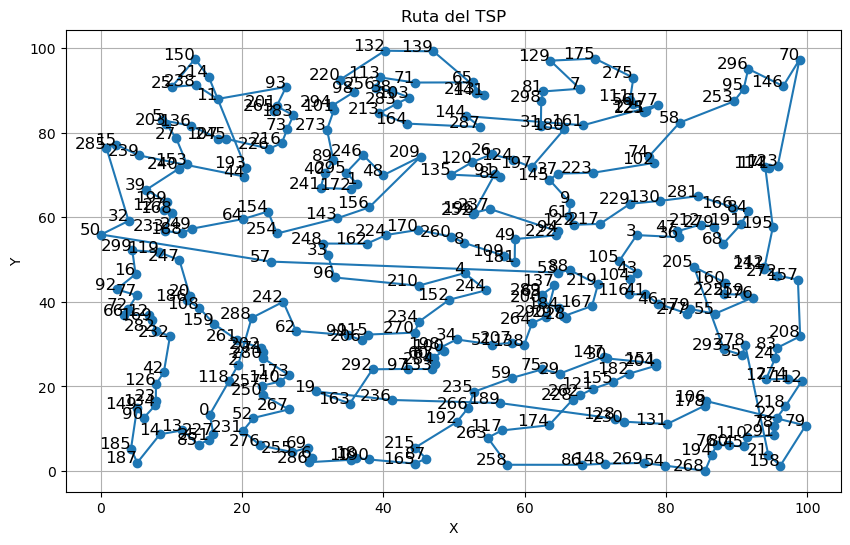

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Leer matriz de distancias desde un archivo
def leer_matriz_distancias(filename):
    with open(filename, 'r') as file:
        matriz = []
        for line in file:
            fila = list(map(float, line.strip().split()))
            matriz.append(fila)
    return np.array(matriz)

# Leer coordenadas desde un archivo
def leer_coordenadas(filename):
    with open(filename, 'r') as file:
        coordenadas = []
        for line in file:
            x, y = map(float, line.strip().split())
            coordenadas.append((x, y))
    return coordenadas

# Algoritmo de colonia de hormigas (ACO)
class ACO:
    def __init__(self, matriz_distancias, num_hormigas, num_iteraciones, alpha=1.0, beta=5.0, rho=0.5, q=100, elitismo=0.1, evaporacion_global=0.1):
        self.matriz_distancias = matriz_distancias
        self.num_ciudades = matriz_distancias.shape[0]
        self.num_hormigas = num_hormigas
        self.num_iteraciones = num_iteraciones
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.elitismo = elitismo
        self.evaporacion_global = evaporacion_global
        self.feromonas = np.ones((self.num_ciudades, self.num_ciudades)) / self.num_ciudades

    def _calcular_probabilidades(self, ciudad_actual, no_visitadas):
        feromonas = self.feromonas[ciudad_actual][no_visitadas]
        visibilidad = 1 / self.matriz_distancias[ciudad_actual][no_visitadas]
        probabilidades = (feromonas ** self.alpha) * (visibilidad ** self.beta)
        return probabilidades / probabilidades.sum()

    def _actualizar_feromonas(self, rutas, costes, mejor_ruta_global):
        # Evaporación global
        self.feromonas *= (1 - self.evaporacion_global)

        # Elitismo: Actualización de feromonas por la mejor hormiga global
        mejor_coste_global = float('inf')
        for ruta, coste in zip(rutas, costes):
            if coste < mejor_coste_global:
                mejor_coste_global = coste
                mejor_ruta_global = ruta

        for i in range(len(mejor_ruta_global) - 1):
            ciudad_actual = mejor_ruta_global[i]
            siguiente_ciudad = mejor_ruta_global[i + 1]
            self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / mejor_coste_global
            self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / mejor_coste_global

        # Actualización de feromonas por las otras hormigas
        for ruta, coste in zip(rutas, costes):
            for i in range(len(ruta) - 1):
                ciudad_actual = ruta[i]
                siguiente_ciudad = ruta[i + 1]
                self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / coste
                self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / coste

    def resolver(self):
        mejor_ruta_global = None
        mejor_coste_global = float('inf')
        for _ in range(self.num_iteraciones):
            rutas = []
            costes = []
            for _ in range(self.num_hormigas):
                ruta = [np.random.randint(self.num_ciudades)]
                for _ in range(self.num_ciudades - 1):
                    ciudad_actual = ruta[-1]
                    no_visitadas = list(set(range(self.num_ciudades)) - set(ruta))
                    probabilidades = self._calcular_probabilidades(ciudad_actual, no_visitadas)
                    siguiente_ciudad = np.random.choice(no_visitadas, p=probabilidades)
                    ruta.append(siguiente_ciudad)
                ruta.append(ruta[0])  # Volver al inicio
                rutas.append(ruta)
                coste = sum(self.matriz_distancias[ruta[i], ruta[i + 1]] for i in range(len(ruta) - 1))
                costes.append(coste)

            # Actualizar feromonas
            self._actualizar_feromonas(rutas, costes, mejor_ruta_global)

            # Actualizar mejor ruta global
            for ruta, coste in zip(rutas, costes):
                if coste < mejor_coste_global:
                    mejor_coste_global = coste
                    mejor_ruta_global = ruta

        return mejor_ruta_global, mejor_coste_global


def mostrar_resultado(coordenadas, ruta):
    x = [coordenadas[i][0] for i in ruta]
    y = [coordenadas[i][1] for i in ruta]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    for i, (xi, yi) in enumerate(coordenadas):
        plt.text(xi, yi, str(i), fontsize=12, ha='right')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Ruta del TSP')
    plt.grid(True)
    plt.show()

# Archivos de entrada
archivo_matriz = 'TSP\Distancia.txt'
archivo_coordenadas = 'TSP\Coordenadas.txt'

# Leer archivos
matriz_distancias = leer_matriz_distancias(archivo_matriz)
coordenadas = leer_coordenadas(archivo_coordenadas)

# Configurar y ejecutar ACO
num_hormigas = 25
num_iteraciones = 100

inicio = time.time()
mejor_semilla = None
mejor_ruta = None
mejor_coste = float('inf')
for semilla in range(100, 101):
    np.random.seed(semilla)
    aco = ACO(matriz_distancias, num_hormigas, num_iteraciones)
    ruta, coste = aco.resolver()
    if coste < mejor_coste:
        mejor_semilla = semilla
        mejor_ruta = ruta
        mejor_coste = coste
    print(f'Semilla: {semilla}, Mejor coste: {coste}')

fin = time.time()

# Mostrar resultado de la mejor semilla
print(f'\nMejor semilla: {mejor_semilla}, Costo de la mejor ruta: {mejor_coste}')
print(f'Ruta de la mejor semilla: {mejor_ruta}')
print(f'\nTiempo de ejecución: {fin - inicio} segundos')
mostrar_resultado(coordenadas, mejor_ruta)


Costo de la mejor ruta: 1352.5924000000005
Ruta: [284, 133, 236, 163, 19, 267, 250, 140, 173, 257, 118, 2, 280, 271, 202, 261, 288, 159, 108, 186, 20, 16, 92, 77, 72, 66, 12, 169, 282, 232, 42, 126, 23, 134, 149, 90, 187, 185, 14, 13, 85, 251, 227, 0, 52, 231, 276, 255, 69, 6, 286, 10, 18, 190, 165, 87, 215, 192, 266, 235, 189, 59, 75, 29, 147, 30, 155, 182, 204, 151, 178, 106, 131, 230, 128, 121, 262, 228, 174, 117, 263, 258, 86, 148, 269, 54, 268, 194, 76, 80, 45, 110, 21, 158, 291, 78, 79, 22, 218, 112, 274, 17, 24, 83, 208, 278, 35, 293, 55, 179, 277, 46, 41, 116, 167, 219, 104, 43, 105, 88, 53, 137, 289, 63, 200, 184, 297, 28, 290, 264, 138, 207, 51, 34, 198, 100, 67, 60, 270, 234, 152, 210, 96, 57, 64, 154, 254, 33, 248, 162, 224, 170, 260, 8, 4, 244, 109, 181, 49, 222, 94, 122, 61, 217, 3, 36, 47, 212, 279, 68, 205, 160, 225, 259, 176, 157, 272, 142, 211, 195, 191, 84, 166, 281, 130, 229, 9, 145, 82, 91, 237, 252, 196, 135, 209, 48, 1, 172, 156, 143, 241, 40, 295, 89, 246, 213,

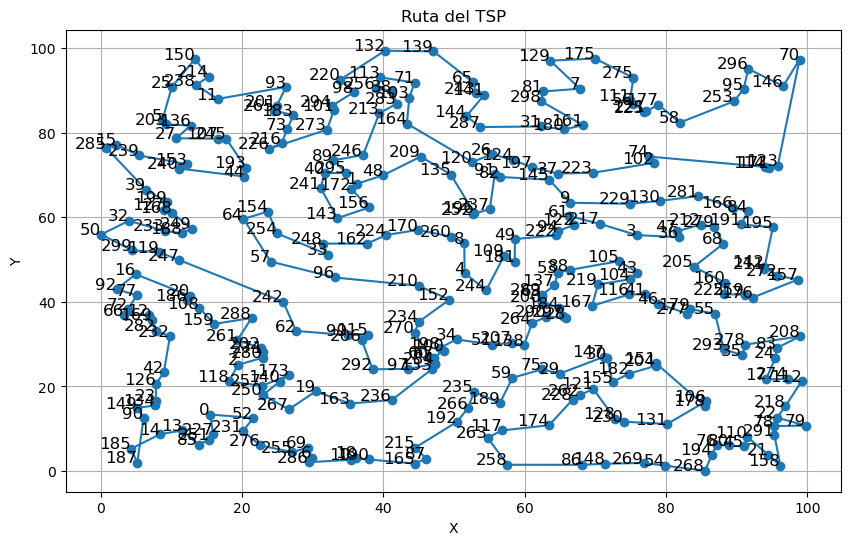

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Leer matriz de distancias desde un archivo
def leer_matriz_distancias(filename):
    with open(filename, 'r') as file:
        matriz = []
        for line in file:
            fila = list(map(float, line.strip().split()))
            matriz.append(fila)
    return np.array(matriz)

# Leer coordenadas desde un archivo
def leer_coordenadas(filename):
    with open(filename, 'r') as file:
        coordenadas = []
        for line in file:
            x, y = map(float, line.strip().split())
            coordenadas.append((x, y))
    return coordenadas

# Función 2-opt para mejorar una ruta
def dos_opt(ruta, matriz_distancias):
    n = len(ruta)
    mejora = True
    while mejora:
        mejora = False
        for i in range(1, n - 2):
            for j in range(i + 1, n - 1):
                if j - i == 1:
                    continue
                costo_actual = (
                    matriz_distancias[ruta[i - 1], ruta[i]]
                    + matriz_distancias[ruta[j], ruta[j + 1]]
                )
                nuevo_costo = (
                    matriz_distancias[ruta[i - 1], ruta[j]]
                    + matriz_distancias[ruta[i], ruta[j + 1]]
                )
                if nuevo_costo < costo_actual:
                    ruta[i:j + 1] = reversed(ruta[i:j + 1])
                    mejora = True
    return ruta

# Algoritmo de colonia de hormigas (ACO)
class ACO:
    def __init__(self, matriz_distancias, num_hormigas, num_iteraciones, alpha=1.0, beta=5.0, rho=0.5, q=100, elitismo=0.1, evaporacion_global=0.1):
        self.matriz_distancias = matriz_distancias
        self.num_ciudades = matriz_distancias.shape[0]
        self.num_hormigas = num_hormigas
        self.num_iteraciones = num_iteraciones
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.elitismo = elitismo
        self.evaporacion_global = evaporacion_global
        self.feromonas = np.ones((self.num_ciudades, self.num_ciudades)) / self.num_ciudades

    def _calcular_probabilidades(self, ciudad_actual, no_visitadas):
        feromonas = self.feromonas[ciudad_actual][no_visitadas]
        visibilidad = 1 / self.matriz_distancias[ciudad_actual][no_visitadas]
        probabilidades = (feromonas ** self.alpha) * (visibilidad ** self.beta)
        return probabilidades / probabilidades.sum()

    def _actualizar_feromonas(self, rutas, costes, mejor_ruta_global):
        self.feromonas *= (1 - self.evaporacion_global)
        mejor_coste_global = float('inf')
        for ruta, coste in zip(rutas, costes):
            if coste < mejor_coste_global:
                mejor_coste_global = coste
                mejor_ruta_global = ruta
        for i in range(len(mejor_ruta_global) - 1):
            ciudad_actual = mejor_ruta_global[i]
            siguiente_ciudad = mejor_ruta_global[i + 1]
            self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / mejor_coste_global
            self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / mejor_coste_global
        for ruta, coste in zip(rutas, costes):
            for i in range(len(ruta) - 1):
                ciudad_actual = ruta[i]
                siguiente_ciudad = ruta[i + 1]
                self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / coste
                self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / coste

    def resolver(self, tiempo_limite):
        mejor_ruta_global = None
        mejor_coste_global = float('inf')
        inicio_tiempo = time.time()
        
        for _ in range(self.num_iteraciones):
            if time.time() - inicio_tiempo > tiempo_limite:
                break
            
            rutas = []
            costes = []
            for _ in range(self.num_hormigas):
                ruta = [np.random.randint(self.num_ciudades)]
                for _ in range(self.num_ciudades - 1):
                    ciudad_actual = ruta[-1]
                    no_visitadas = list(set(range(self.num_ciudades)) - set(ruta))
                    probabilidades = self._calcular_probabilidades(ciudad_actual, no_visitadas)
                    siguiente_ciudad = np.random.choice(no_visitadas, p=probabilidades)
                    ruta.append(siguiente_ciudad)
                ruta.append(ruta[0])  # Volver al inicio
                ruta = dos_opt(ruta, self.matriz_distancias)  # Aplicar 2-opt
                rutas.append(ruta)
                coste = sum(self.matriz_distancias[ruta[i], ruta[i + 1]] for i in range(len(ruta) - 1))
                costes.append(coste)
            
            self._actualizar_feromonas(rutas, costes, mejor_ruta_global)
            for ruta, coste in zip(rutas, costes):
                if coste < mejor_coste_global:
                    mejor_coste_global = coste
                    mejor_ruta_global = ruta

        return mejor_ruta_global, mejor_coste_global

# Mostrar resultado
def mostrar_resultado(coordenadas, ruta):
    x = [coordenadas[i][0] for i in ruta]
    y = [coordenadas[i][1] for i in ruta]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    for i, (xi, yi) in enumerate(coordenadas):
        plt.text(xi, yi, str(i), fontsize=12, ha='right')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Ruta del TSP')
    plt.grid(True)
    plt.show()

# Archivos de entrada
archivo_matriz = 'TSP\Distancia.txt'
archivo_coordenadas = 'TSP\Coordenadas.txt'

# Leer archivos
matriz_distancias = leer_matriz_distancias(archivo_matriz)
coordenadas = leer_coordenadas(archivo_coordenadas)

# Configurar y ejecutar ACO
num_hormigas = 25
num_iteraciones = 100
tiempo_limite = 110  # Límite de tiempo en segundos

inicio = time.time()
aco = ACO(matriz_distancias, num_hormigas, num_iteraciones)
ruta, coste = aco.resolver(tiempo_limite)
fin = time.time()

# Mostrar resultado
print(f'\nCosto de la mejor ruta: {coste}')
print(f'Ruta: {ruta}')
print(f'\nTiempo de ejecución: {fin - inicio:.2f} segundos')
mostrar_resultado(coordenadas, ruta)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch

# Leer matriz de distancias desde un archivo
def leer_matriz_distancias(filename):
    with open(filename, 'r') as file:
        matriz = []
        for line in file:
            fila = list(map(float, line.strip().split()))
            matriz.append(fila)
    return np.array(matriz)

# Leer coordenadas desde un archivo
def leer_coordenadas(filename):
    with open(filename, 'r') as file:
        coordenadas = []
        for line in file:
            x, y = map(float, line.strip().split())
            coordenadas.append((x, y))
    return coordenadas

# Función 2-opt para mejorar una ruta
def dos_opt(ruta, matriz_distancias):
    n = len(ruta)
    mejora = True
    while mejora:
        mejora = False
        for i in range(1, n - 2):
            for j in range(i + 1, n - 1):
                if j - i == 1:
                    continue
                costo_actual = (
                    matriz_distancias[ruta[i - 1], ruta[i]]
                    + matriz_distancias[ruta[j], ruta[j + 1]]
                )
                nuevo_costo = (
                    matriz_distancias[ruta[i - 1], ruta[j]]
                    + matriz_distancias[ruta[i], ruta[j + 1]]
                )
                if nuevo_costo < costo_actual:
                    ruta[i:j + 1] = reversed(ruta[i:j + 1])
                    mejora = True
    return ruta

# Algoritmo de colonia de hormigas (ACO) con PyTorch y CUDA
class ACO:
    def __init__(self, matriz_distancias, num_hormigas, num_iteraciones, alpha=1.0, beta=5.0, rho=0.5, q=100, elitismo=0.1, evaporacion_global=0.1):
        # Mover la matriz de distancias y las feromonas a la GPU si CUDA está disponible
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Convertir matrices a tensores en la GPU
        self.matriz_distancias = torch.tensor(matriz_distancias, dtype=torch.float32).to(self.device)
        self.num_ciudades = self.matriz_distancias.shape[0]
        self.num_hormigas = num_hormigas
        self.num_iteraciones = num_iteraciones
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.elitismo = elitismo
        self.evaporacion_global = evaporacion_global
        
        # Inicializar las feromonas en la GPU
        self.feromonas = torch.ones((self.num_ciudades, self.num_ciudades), dtype=torch.float32).to(self.device) / self.num_ciudades

    def _calcular_probabilidades(self, ciudad_actual, no_visitadas):
        # Asegurarse de que las operaciones se realicen en la GPU
        feromonas = self.feromonas[ciudad_actual][no_visitadas]
        visibilidad = 1 / self.matriz_distancias[ciudad_actual][no_visitadas]
        probabilidades = (feromonas ** self.alpha) * (visibilidad ** self.beta)
        return probabilidades / probabilidades.sum()

    def _actualizar_feromonas(self, rutas, costes, mejor_ruta_global):
        # Asegurarse de que las operaciones se realicen en la GPU
        self.feromonas *= (1 - self.evaporacion_global)
        mejor_coste_global = float('inf')
        for ruta, coste in zip(rutas, costes):
            if coste < mejor_coste_global:
                mejor_coste_global = coste
                mejor_ruta_global = ruta
        for i in range(len(mejor_ruta_global) - 1):
            ciudad_actual = mejor_ruta_global[i]
            siguiente_ciudad = mejor_ruta_global[i + 1]
            self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / mejor_coste_global
            self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / mejor_coste_global
        for ruta, coste in zip(rutas, costes):
            for i in range(len(ruta) - 1):
                ciudad_actual = ruta[i]
                siguiente_ciudad = ruta[i + 1]
                self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / coste
                self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / coste

    def resolver(self, tiempo_limite):
        mejor_ruta_global = None
        mejor_coste_global = float('inf')
        inicio_tiempo = time.time()
        
        for _ in range(self.num_iteraciones):
            if time.time() - inicio_tiempo > tiempo_limite:
                break
            
            rutas = []
            costes = []
            
            # Paralelizar la simulación de las hormigas usando PyTorch y CUDA
            for _ in range(self.num_hormigas):
                ruta = [np.random.randint(self.num_ciudades)]
                for _ in range(self.num_ciudades - 1):
                    ciudad_actual = ruta[-1]
                    no_visitadas = list(set(range(self.num_ciudades)) - set(ruta))
                    probabilidades = self._calcular_probabilidades(ciudad_actual, no_visitadas)
                    siguiente_ciudad = np.random.choice(no_visitadas, p=probabilidades.cpu().numpy())
                    ruta.append(siguiente_ciudad)
                ruta.append(ruta[0])  # Volver al inicio
                ruta = dos_opt(ruta, self.matriz_distancias.cpu().numpy())  # Aplicar 2-opt
                rutas.append(ruta)
                coste = sum(self.matriz_distancias[ruta[i], ruta[i + 1]].item() for i in range(len(ruta) - 1))
                costes.append(coste)
            
            self._actualizar_feromonas(rutas, costes, mejor_ruta_global)
            for ruta, coste in zip(rutas, costes):
                if coste < mejor_coste_global:
                    mejor_coste_global = coste
                    mejor_ruta_global = ruta

        return mejor_ruta_global, mejor_coste_global

# Archivos de entrada
archivo_matriz = 'TSP\Distancia.txt'
archivo_coordenadas = 'TSP\Coordenadas.txt'

# Leer archivos
matriz_distanPascias = leer_matriz_distancias(archivo_matriz)
coordenadas = leer_coordenadas(archivo_coordenadas)

# Configurar y ejecutar ACO
num_hormigas = 25
num_iteraciones = 100
tiempo_limite = 110  # Límite de tiempo en segundos

inicio = time.time()
aco = ACO(matriz_distancias, num_hormigas, num_iteraciones)
ruta, coste = aco.resolver(tiempo_limite)
fin = time.time()

# Mostrar resultado
print(f'\nCosto de la mejor ruta: {coste}')
print(f'Ruta: {ruta}')
print(f'\nTiempo de ejecución: {fin - inicio:.2f} segundos')
Graficar(coordenadas, mejor_ruta)


Costo de la mejor ruta: 1362.8760051131248
Ruta: [50, 299, 16, 92, 77, 72, 66, 169, 12, 282, 232, 42, 126, 23, 134, 149, 90, 187, 185, 14, 13, 85, 251, 227, 0, 118, 2, 280, 271, 62, 202, 261, 159, 108, 186, 20, 288, 242, 99, 206, 115, 270, 34, 198, 100, 67, 60, 284, 133, 97, 292, 236, 163, 19, 173, 140, 257, 250, 267, 52, 231, 276, 69, 255, 286, 6, 10, 18, 190, 165, 87, 215, 192, 266, 235, 189, 59, 75, 29, 121, 262, 228, 174, 117, 263, 258, 86, 148, 269, 54, 268, 194, 76, 80, 45, 110, 158, 21, 291, 78, 79, 22, 218, 112, 274, 17, 24, 83, 208, 278, 35, 293, 151, 204, 106, 178, 131, 230, 128, 155, 182, 30, 147, 138, 207, 51, 264, 290, 297, 28, 184, 200, 63, 289, 244, 4, 152, 234, 210, 96, 33, 248, 162, 224, 170, 260, 8, 196, 252, 237, 49, 109, 181, 137, 53, 88, 219, 167, 116, 41, 46, 179, 277, 55, 176, 259, 157, 272, 211, 142, 160, 225, 205, 104, 43, 105, 36, 47, 212, 279, 68, 191, 195, 84, 166, 281, 171, 114, 123, 70, 146, 296, 95, 253, 58, 177, 125, 221, 56, 111, 275, 175, 129, 7, 81, 

AttributeError: 'list' object has no attribute 'iloc'

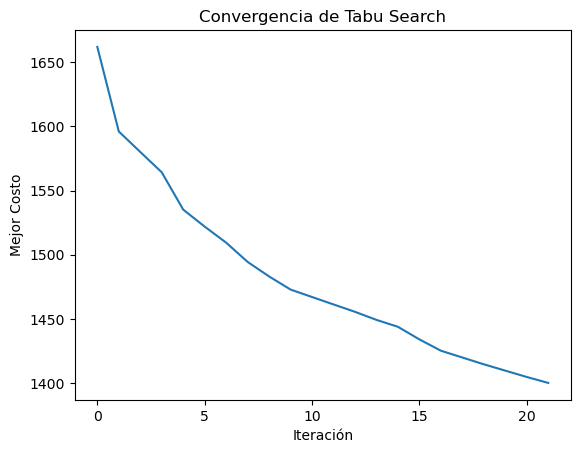

Mejor ruta encontrada: [0, 227, 251, 85, 13, 52, 231, 276, 69, 255, 286, 6, 10, 18, 190, 215, 165, 87, 192, 266, 235, 189, 59, 75, 29, 262, 228, 121, 155, 182, 147, 30, 151, 204, 106, 178, 131, 230, 128, 174, 117, 263, 258, 86, 148, 269, 54, 268, 194, 76, 80, 45, 110, 291, 78, 22, 158, 21, 79, 218, 112, 274, 17, 293, 278, 35, 24, 83, 208, 157, 272, 211, 142, 195, 68, 205, 160, 225, 259, 176, 55, 179, 277, 46, 41, 116, 167, 219, 104, 43, 105, 3, 47, 36, 212, 279, 191, 84, 166, 281, 130, 229, 217, 9, 61, 122, 94, 222, 49, 109, 181, 53, 88, 137, 289, 63, 200, 184, 297, 28, 290, 264, 138, 207, 51, 34, 198, 100, 67, 60, 284, 133, 97, 292, 206, 115, 99, 62, 202, 271, 280, 2, 118, 257, 250, 267, 236, 163, 19, 173, 140, 261, 159, 108, 186, 20, 288, 242, 57, 32, 50, 239, 15, 285, 25, 238, 214, 150, 11, 193, 44, 64, 154, 254, 143, 241, 48, 246, 89, 40, 295, 1, 172, 156, 170, 224, 162, 248, 33, 96, 270, 234, 210, 152, 244, 4, 8, 260, 252, 196, 237, 82, 91, 209, 135, 120, 26, 124, 197, 145, 37, 22

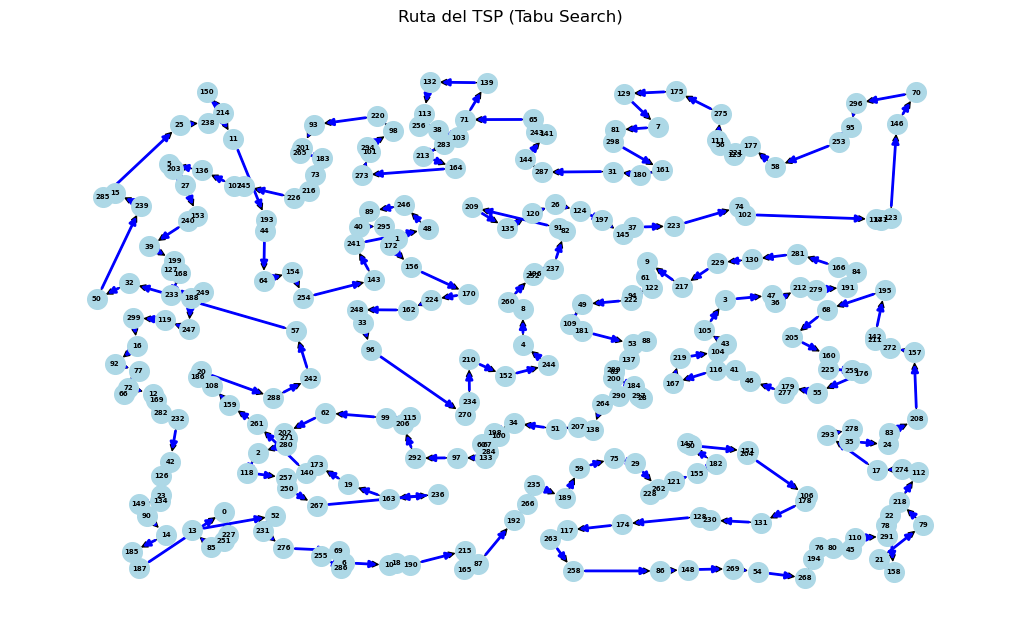

In [ ]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt
import networkx as nx

# Leer coordenadas desde un archivo
def leer_coordenadas(filename):
    with open(filename, 'r') as file:
        coordenadas = []
        for line in file:
            x, y = map(float, line.strip().split())
            coordenadas.append((x, y))
    return coordenadas

# Función para calcular el costo de una ruta
def calcular_costo_ruta(ruta, matriz_distancias):
    return sum(matriz_distancias[ruta[i], ruta[i + 1]] for i in range(len(ruta) - 1))

# Función para obtener la solución inicial con el algoritmo Nearest Neighbor
def nearest_neighbor(matriz_distancias):
    n = len(matriz_distancias)
    ruta = [0]  # Comienza desde la ciudad 0
    visitados = [False] * n
    visitados[0] = True
    for _ in range(n - 1):
        ultimo_ciudad = ruta[-1]
        siguiente_ciudad = min(
            [(i, matriz_distancias[ultimo_ciudad][i]) for i in range(n) if not visitados[i]], key=lambda x: x[1]
        )[0]
        ruta.append(siguiente_ciudad)
        visitados[siguiente_ciudad] = True
    ruta.append(ruta[0])  # Regresar a la ciudad inicial
    return ruta

# Función de intercambio 2-opt
def generar_vecinos_2opt(ruta):
    vecinos = []
    n = len(ruta)
    for i in range(1, n - 2):
        for j in range(i + 1, n - 1):
            nuevo_vecino = ruta[:i] + ruta[i:j][::-1] + ruta[j:]
            vecinos.append(nuevo_vecino)
    return vecinos

# Implementación de Tabu Search
def tabu_search(matriz_distancias, tiempo_maximo=60, tamaño_tabu=10):
    inicio = time.time()
    num_ciudades = len(matriz_distancias)
    
    # Generar una solución inicial utilizando Nearest Neighbor
    mejor_ruta = nearest_neighbor(matriz_distancias)
    mejor_costo = calcular_costo_ruta(mejor_ruta, matriz_distancias)
    
    # Configuración inicial
    ruta_actual = mejor_ruta[:]
    costo_actual = mejor_costo
    lista_tabu = []
    historial_costos = [mejor_costo]
    
    while time.time() - inicio < tiempo_maximo:
        # Generar vecinos utilizando 2-opt
        vecinos = generar_vecinos_2opt(ruta_actual)
        
        # Evaluar los costos de los vecinos
        vecinos_costos = [(ruta, calcular_costo_ruta(ruta, matriz_distancias)) for ruta in vecinos]
        
        # Ordenar vecinos por costo ascendente
        vecinos_costos.sort(key=lambda x: x[1])
        
        # Seleccionar el mejor vecino no tabú o una solución aspiracional
        seleccionado = None
        for vecino, costo in vecinos_costos:
            if vecino not in lista_tabu or costo < mejor_costo:
                seleccionado = (vecino, costo)
                break
        
        # Actualizar la solución actual y el mejor encontrado
        if seleccionado:
            ruta_actual, costo_actual = seleccionado
            if costo_actual < mejor_costo:
                mejor_ruta = ruta_actual[:]
                mejor_costo = costo_actual
            
            # Actualizar la lista Tabú
            lista_tabu.append(ruta_actual)
            if len(lista_tabu) > tamaño_tabu:
                lista_tabu.pop(0)
        
        # Registrar el costo actual para graficar la convergencia
        historial_costos.append(mejor_costo)
    
    # Graficar la convergencia
    plt.plot(historial_costos)
    plt.xlabel('Iteración')
    plt.ylabel('Mejor Costo')
    plt.title('Convergencia de Tabu Search')
    plt.show()
    
    return mejor_ruta, mejor_costo, time.time() - inicio

# Leer matriz de distancias
def leer_matriz_distancias(filename):
    with open(filename, 'r') as file:
        matriz = []
        for line in file:
            fila = list(map(float, line.strip().split()))
            matriz.append(fila)
    return np.array(matriz)

# Ejecución
archivo_matriz = 'TSP\Distancia.txt'
matriz_distancias = leer_matriz_distancias(archivo_matriz)

# Parámetros de Tabu Search
tiempo_maximo = 110 # Tiempo límite en segundos
tamaño_tabu = 25    # Tamaño de la lista Tabú

# Ejecutar Tabu Search
mejor_ruta, mejor_costo, tiempo_total = tabu_search(matriz_distancias, tiempo_maximo, tamaño_tabu)

# Resultados
print("Mejor ruta encontrada:", mejor_ruta)
print("Costo de la mejor ruta:", mejor_costo)
print("Tiempo total de ejecución:", tiempo_total, "segundos")
print("Semilla:", random.getstate()[1][0])

# Graficar la ruta
def Graficar(coordenadas, ruta):    
    G = nx.DiGraph()  # Grafo dirigido para la ruta

    # Añadir nodos y sus posiciones
    for i, (x, y) in enumerate(coordenadas):
        G.add_node(i, pos=(x, y))

    # Añadir aristas según la ruta
    for i in range(len(ruta) - 1):
        G.add_edge(ruta[i], ruta[i + 1])

    # Extraer posiciones para la visualización
    pos = nx.get_node_attributes(G, 'pos')

    # Dibujar el grafo
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightblue', font_size=5, font_color='black', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges, edge_color='blue', width=2, arrows=True)
    plt.title("Ruta del TSP (Tabu Search)")
    plt.grid(True)
    plt.show()

# Graficar la mejor ruta obtenida
# Asumiendo que tienes un archivo de coordenadas
coordenadas = leer_coordenadas('TSP\Coordenadas.txt')
Graficar(coordenadas, mejor_ruta)


Costo de la mejor ruta: 1427.9017000000003
Ruta: [55, 225, 160, 205, 104, 104, 219, 184, 290, 184, 297, 289, 63, 51, 34, 100, 198, 60, 67, 284, 133, 97, 292, 236, 163, 19, 267, 52, 231, 276, 255, 69, 6, 286, 10, 18, 190, 165, 87, 215, 258, 86, 148, 269, 54, 268, 194, 76, 80, 45, 21, 158, 79, 291, 78, 22, 218, 112, 274, 17, 24, 83, 278, 35, 293, 204, 151, 147, 30, 182, 155, 121, 262, 228, 174, 117, 263, 67, 60, 198, 60, 67, 75, 29, 138, 207, 264, 290, 184, 297, 28, 167, 116, 169, 12, 66, 72, 77, 92, 16, 299, 119, 247, 249, 188, 233, 168, 127, 199, 39, 240, 153, 44, 193, 241, 154, 64, 254, 57, 162, 224, 170, 260, 8, 252, 196, 237, 91, 82, 287, 144, 164, 213, 283, 103, 38, 256, 113, 132, 139, 65, 243, 141, 7, 161, 180, 31, 298, 81, 129, 175, 275, 111, 56, 125, 221, 177, 58, 74, 102, 223, 37, 145, 197, 124, 26, 120, 135, 209, 48, 246, 89, 40, 295, 1, 172, 156, 143, 248, 33, 96, 210, 152, 244, 4, 181, 109, 49, 222, 94, 122, 217, 3, 105, 43, 104, 219, 88, 53, 137, 200, 289, 63, 51, 34, 100,

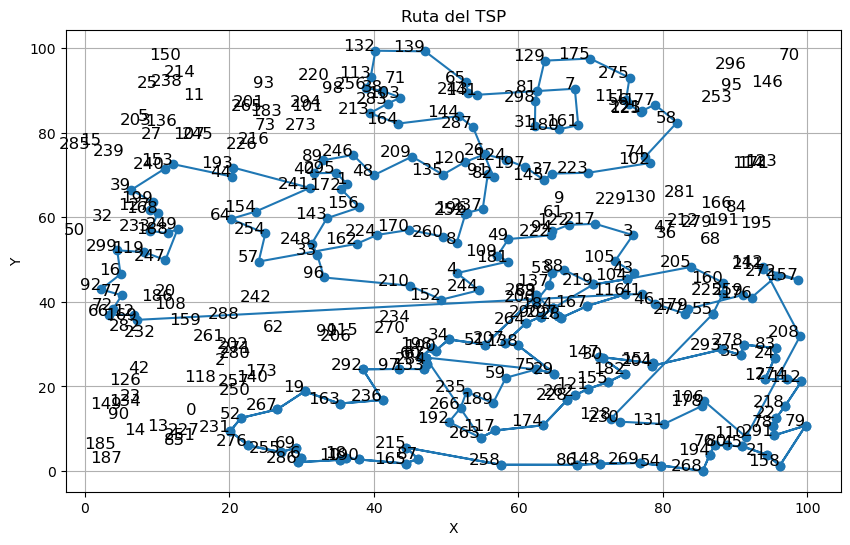

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import time

def leer_matriz_distancias(filename):
    with open(filename, 'r') as file:
        matriz = []
        for line in file:
            fila = list(map(float, line.strip().split()))
            matriz.append(fila)
    return np.array(matriz)

def leer_coordenadas(filename):
    with open(filename, 'r') as file:
        coordenadas = []
        for line in file:
            x, y = map(float, line.strip().split())
            coordenadas.append((x, y))
    return coordenadas

def dos_opt(ruta, matriz_distancias):
    n = len(ruta)
    mejor_costo = float('inf')
    mejor_ruta = ruta.copy()
    
    for i in range(1, n - 2):
        for j in range(i + 1, n - 1):
            if j - i == 1:
                continue
            nuevo_costo = (
                matriz_distancias[ruta[i - 1], ruta[j]]
                + matriz_distancias[ruta[i], ruta[j + 1]]
            )
            if nuevo_costo < mejor_costo:
                mejor_costo = nuevo_costo
                mejor_ruta[i:j + 1] = reversed(ruta[i:j + 1])
    
    return mejor_ruta, mejor_costo

class ACO:
    def __init__(self, matriz_distancias, num_hormigas, num_iteraciones, alpha=1.0, beta=5.0, rho=0.5, q=100, elitismo=0.1, evaporacion_global=0.1):
        self.matriz_distancias = matriz_distancias
        self.num_ciudades = matriz_distancias.shape[0]
        self.num_hormigas = num_hormigas
        self.num_iteraciones = num_iteraciones
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.elitismo = elitismo
        self.evaporacion_global = evaporacion_global
        self.feromonas = np.ones((self.num_ciudades, self.num_ciudades)) / self.num_ciudades

    def _calcular_probabilidades(self, ciudad_actual, no_visitadas):
        feromonas = self.feromonas[ciudad_actual][no_visitadas]
        visibilidad = 1 / self.matriz_distancias[ciudad_actual][no_visitadas]
        probabilidades = (feromonas ** self.alpha) * (visibilidad ** self.beta)
        return probabilidades / probabilidades.sum()

    def _actualizar_feromonas(self, rutas, costes, mejor_ruta_global):
        self.feromonas *= (1 - self.evaporacion_global)
        mejor_coste_global = float('inf')
        mejor_ruta_global = None
        for ruta, coste in zip(rutas, costes):
            if coste < mejor_coste_global:
                mejor_coste_global = coste
                mejor_ruta_global = ruta
        for i in range(len(mejor_ruta_global) - 1):
            ciudad_actual = mejor_ruta_global[i]
            siguiente_ciudad = mejor_ruta_global[i + 1]
            self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / mejor_coste_global
            self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / mejor_coste_global
        for ruta, coste in zip(rutas, costes):
            for i in range(len(ruta) - 1):
                ciudad_actual = ruta[i]
                siguiente_ciudad = ruta[i + 1]
                self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / coste
                self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / coste

    def resolver(self, tiempo_limite):
        mejor_ruta_global = None
        mejor_coste_global = float('inf')
        inicio_tiempo = time.time()
        
        with ProcessPoolExecutor() as executor:
            for _ in range(self.num_iteraciones):
                if time.time() - inicio_tiempo > tiempo_limite:
                    break
                
                rutas = []
                costes = []
                for _ in range(self.num_hormigas):
                    ruta = [np.random.randint(self.num_ciudades)]
                    for _ in range(self.num_ciudades - 1):
                        ciudad_actual = ruta[-1]
                        no_visitadas = list(set(range(self.num_ciudades)) - set(ruta))
                        probabilidades = self._calcular_probabilidades(ciudad_actual, no_visitadas)
                        siguiente_ciudad = np.random.choice(no_visitadas, p=probabilidades)
                        ruta.append(siguiente_ciudad)
                    ruta.append(ruta[0])  # Volver al inicio
                    ruta = dos_opt(ruta, self.matriz_distancias)[0]  # Aplicar 2-opt
                    rutas.append(ruta)
                    coste = sum(self.matriz_distancias[ruta[i], ruta[i + 1]] for i in range(len(ruta) - 1))
                    costes.append(coste)
                
                self._actualizar_feromonas(rutas, costes, mejor_ruta_global)
                for ruta, coste in zip(rutas, costes):
                    if coste < mejor_coste_global:
                        mejor_coste_global = coste
                        mejor_ruta_global = ruta

        return mejor_ruta_global, mejor_coste_global

def mostrar_resultado(coordenadas, ruta):
    x = [coordenadas[i][0] for i in ruta]
    y = [coordenadas[i][1] for i in ruta]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    for i, (xi, yi) in enumerate(coordenadas):
        plt.text(xi, yi, str(i), fontsize=12, ha='right')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Ruta del TSP')
    plt.grid(True)
    plt.show()

# Archivos de entrada
archivo_matriz = 'TSP\Distancia.txt'
archivo_coordenadas = 'TSP\Coordenadas.txt'

# Configurar y ejecutar ACO
num_hormigas = 20
num_iteraciones = 50
tiempo_limite = 60  # Límite de tiempo en segundos

inicio = time.time()
aco = ACO(matriz_distancias, num_hormigas, num_iteraciones)
ruta, coste = aco.resolver(tiempo_limite)
fin = time.time()

# Mostrar resultado
print(f'\nCosto de la mejor ruta: {coste}')
print(f'Ruta: {ruta}')
print(f'\nTiempo de ejecución: {fin - inicio:.2f} segundos')
mostrar_resultado(coordenadas, ruta)


In [ ]:
import torch
import torch.multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import time

def leer_matriz_distancias(filename):
    with open(filename, 'r') as file:
        matriz = []
        for line in file:
            fila = list(map(float, line.strip().split()))
            matriz.append(fila)
    return np.array(matriz)

def leer_coordenadas(filename):
    with open(filename, 'r') as file:
        coordenadas = []
        for line in file:
            x, y = map(float, line.strip().split())
            coordenadas.append((x, y))
        return coordenadas

def dos_opt(ruta, matriz_distancias):
    n = len(ruta)
    mejor_costo = float('inf')
    mejor_ruta = ruta.copy()
    
    for i in range(1, n - 2):
        for j in range(i + 1, n - 1):
            if j - i == 1:
                continue
            nuevo_costo = (
                matriz_distancias[ruta[i - 1], ruta[j]]
                + matriz_distancias[ruta[i], ruta[j + 1]]
            )
            if nuevo_costo < mejor_costo:
                mejor_costo = nuevo_costo
                mejor_ruta[i:j + 1] = reversed(ruta[i:j + 1])
    
    return mejor_ruta, mejor_costo

class ACO:
    def __init__(self, matriz_distancias, num_hormigas, num_iteraciones, alpha=1.0, beta=5.0, rho=0.5, q=100, elitismo=0.1, evaporacion_global=0.1):
        self.matriz_distancias = torch.tensor(matriz_distancias)
        self.num_ciudades = self.matriz_distancias.shape[0]
        self.num_hormigas = num_hormigas
        self.num_iteraciones = num_iteraciones
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.elitismo = elitismo
        self.evaporacion_global = evaporacion_global
        self.feromonas = torch.ones((self.num_ciudades, self.num_ciudades)) / self.num_ciudades

    def _calcular_probabilidades(self, ciudad_actual, no_visitadas):
        feromonas = self.feromonas[ciudad_actual][no_visitadas]
        visibilidad = 1 / self.matriz_distancias[ciudad_actual][no_visitadas]
        probabilidades = (feromonas ** self.alpha) * (visibilidad ** self.beta)
        return probabilidades / probabilidades.sum()

    def _actualizar_feromonas(self, rutas, costes, mejor_ruta_global):
        self.feromonas *= (1 - self.evaporacion_global)
        mejor_coste_global = float('inf')
        mejor_ruta_global = None
        for ruta, coste in zip(rutas, costes):
            if coste < mejor_coste_global:
                mejor_coste_global = coste
                mejor_ruta_global = ruta
        for i in range(len(mejor_ruta_global) - 1):
            ciudad_actual = mejor_ruta_global[i]
            siguiente_ciudad = mejor_ruta_global[i + 1]
            self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / mejor_coste_global
            self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / mejor_coste_global
        for ruta, coste in zip(rutas, costes):
            for i in range(len(ruta) - 1):
                ciudad_actual = ruta[i]
                siguiente_ciudad = ruta[i + 1]
                self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / coste
                self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / coste

    def resolver(self, tiempo_limite):
        mejor_ruta_global = None
        mejor_coste_global = float('inf')
        inicio_tiempo = time.time()
        
        def proceso_hormiga(args):
            num_iteraciones, matriz_distancias, alpha, beta, rho, q, elitismo, evaporacion_global = args
            
            mejor_ruta_local = None
            mejor_coste_local = float('inf')
            
            for _ in range(num_iteraciones):
                if time.time() - inicio_tiempo > tiempo_limite:
                    break
                
                ruta = torch.randint(0, matriz_distancias.shape[0], (self.num_hormigas,))
                
                for _ in range(matriz_distancias.shape[0] - 1):
                    ciudad_actual = ruta[-1]
                    no_visitadas = set(range(matriz_distancias.shape[0])) - set(ruta)
                    probabilidades = self._calcular_probabilidades(ciudad_actual, no_visitadas)
                    siguiente_ciudad = torch.multinomial(probabilidades, num_samples=1).item()
                    ruta = torch.cat([ruta, torch.tensor([siguiente_ciudad])])
                
                ruta = dos_opt(ruta.numpy(), matriz_distancias.numpy())[0]
                coste = sum(matriz_distancias[ruta[i], ruta[i + 1]] for i in range(len(ruta) - 1))
                
                if coste < mejor_coste_local:
                    mejor_coste_local = coste
                    mejor_ruta_local = ruta.tolist()
            
            return mejor_ruta_local, mejor_coste_local

        with mp.Pool(processes=mp.cpu_count()) as pool:
            resultados = pool.map(proceso_hormiga, [(num_iteraciones, self.matriz_distancias, self.alpha, self.beta, self.rho, self.q, self.elitismo, self.evaporacion_global)] * self.num_hormigas)

        rutas, costes = zip(*resultados)
        
        self._actualizar_feromonas(rutas, costes, mejor_ruta_global)
        for ruta, coste in zip(rutas, costes):
            if coste < mejor_coste_global:
                mejor_coste_global = coste
                mejor_ruta_global = ruta

        return mejor_ruta_global, mejor_coste_global

def mostrar_resultado(coordenadas, ruta):
    x = [coordenadas[i][0] for i in ruta]
    y = [coordenadas[i][1] for i in ruta]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    for i, (xi, yi) in enumerate(coordenadas):
        plt.text(xi, yi, str(i), fontsize=12, ha='right')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Ruta del TSP')
    plt.grid(True)
    plt.show()

# Archivos de entrada
archivo_matriz = 'TSP\Distancia.txt'
archivo_coordenadas = 'TSP\Coordenadas.txt'

# Configurar y ejecutar ACO
num_hormigas = 30
num_iteraciones = 100
tiempo_limite = 120  # Límite de tiempo en segundos

inicio = time.time()
aco = ACO(leer_matriz_distancias(archivo_matriz), num_hormigas, num_iteraciones)
ruta, coste = aco.resolver(tiempo_limite)
fin = time.time()

# Mostrar resultado
print(f'\nCosto de la mejor ruta: {coste}')
print(f'Ruta: {ruta}')
print(f'\nTiempo de ejecución: {fin - inicio:.2f} segundos')
mostrar_resultado(coordenadas, ruta)


AttributeError: Can't pickle local object 'ACO.resolver.<locals>.proceso_hormiga'


Costo de la mejor ruta: 1354.3671
Ruta: [289, 63, 200, 184, 28, 297, 290, 264, 138, 207, 51, 34, 198, 100, 67, 60, 284, 133, 97, 292, 236, 163, 19, 140, 173, 257, 250, 267, 52, 231, 276, 255, 69, 6, 286, 10, 18, 190, 165, 87, 215, 192, 266, 235, 59, 75, 29, 147, 30, 121, 262, 228, 174, 189, 117, 263, 258, 86, 148, 269, 54, 131, 128, 230, 155, 182, 204, 151, 106, 178, 110, 45, 80, 76, 194, 268, 158, 21, 79, 291, 78, 22, 218, 112, 274, 17, 24, 83, 208, 278, 35, 293, 277, 179, 55, 225, 160, 205, 68, 259, 176, 157, 272, 211, 142, 195, 191, 84, 166, 279, 212, 36, 47, 281, 114, 171, 123, 146, 70, 296, 95, 253, 58, 177, 125, 221, 56, 111, 275, 175, 129, 7, 81, 298, 31, 180, 161, 74, 102, 130, 229, 217, 3, 105, 43, 104, 46, 41, 116, 167, 219, 88, 53, 181, 109, 49, 94, 222, 122, 61, 9, 223, 145, 37, 197, 124, 26, 287, 144, 141, 243, 65, 139, 132, 113, 256, 38, 71, 103, 283, 213, 164, 209, 48, 246, 89, 295, 40, 241, 1, 172, 156, 135, 120, 91, 82, 237, 252, 196, 8, 260, 170, 224, 162, 143, 248, 

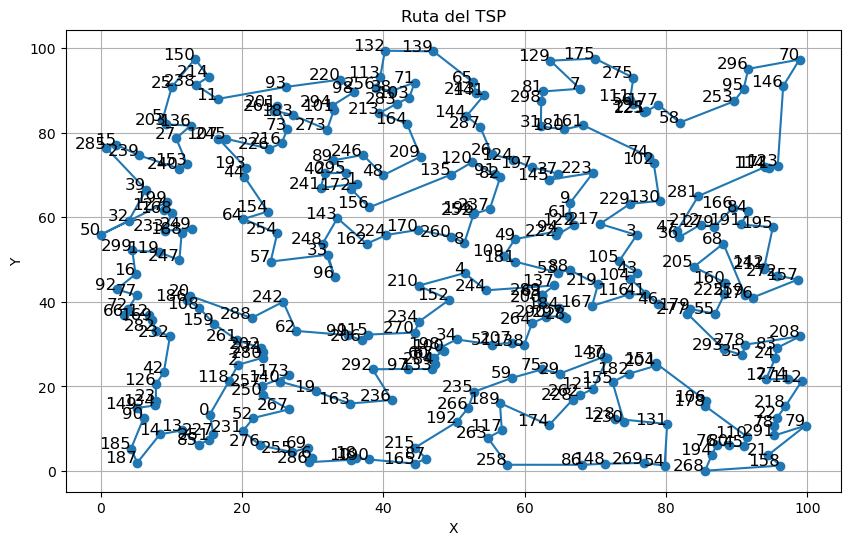

In [ ]:
# Ajustes para optimización de ACO y 2-opt

class ACO:
    def __init__(self, matriz_distancias, num_hormigas, num_iteraciones, alpha=1.0, beta=5.0, rho=0.5, q=100, elitismo=0.1, evaporacion_global=0.1):
        self.matriz_distancias = matriz_distancias
        self.num_ciudades = matriz_distancias.shape[0]
        self.num_hormigas = num_hormigas
        self.num_iteraciones = num_iteraciones
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.elitismo = elitismo
        self.evaporacion_global = evaporacion_global
        self.feromonas = np.ones((self.num_ciudades, self.num_ciudades)) / self.num_ciudades

    def _calcular_probabilidades(self, ciudad_actual, no_visitadas):
        feromonas = self.feromonas[ciudad_actual][no_visitadas]
        visibilidad = 1 / self.matriz_distancias[ciudad_actual][no_visitadas]
        probabilidades = (feromonas ** self.alpha) * (visibilidad ** self.beta)
        return probabilidades / probabilidades.sum()

    def _actualizar_feromonas(self, rutas, costes, mejor_ruta_global):
        self.feromonas *= (1 - self.evaporacion_global)
        mejor_coste_global = float('inf')
        for ruta, coste in zip(rutas, costes):
            if coste < mejor_coste_global:
                mejor_coste_global = coste
                mejor_ruta_global = ruta
        for i in range(len(mejor_ruta_global) - 1):
            ciudad_actual = mejor_ruta_global[i]
            siguiente_ciudad = mejor_ruta_global[i + 1]
            self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / mejor_coste_global
            self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / mejor_coste_global
        for ruta, coste in zip(rutas, costes):
            for i in range(len(ruta) - 1):
                ciudad_actual = ruta[i]
                siguiente_ciudad = ruta[i + 1]
                self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / coste
                self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / coste

    def resolver(self, tiempo_limite):
        mejor_ruta_global = None
        mejor_coste_global = float('inf')
        inicio_tiempo = time.time()
        
        for _ in range(self.num_iteraciones):
            if time.time() - inicio_tiempo > tiempo_limite:
                break
            
            rutas = []
            costes = []
            for _ in range(self.num_hormigas):
                ruta = [np.random.randint(self.num_ciudades)]
                for _ in range(self.num_ciudades - 1):
                    ciudad_actual = ruta[-1]
                    no_visitadas = list(set(range(self.num_ciudades)) - set(ruta))
                    probabilidades = self._calcular_probabilidades(ciudad_actual, no_visitadas)
                    siguiente_ciudad = np.random.choice(no_visitadas, p=probabilidades)
                    ruta.append(siguiente_ciudad)
                ruta.append(ruta[0])  # Volver al inicio
                # Aplicar 2-opt pero con límite de iteraciones
                ruta = dos_opt(ruta, self.matriz_distancias)  # Aplicar 2-opt
                rutas.append(ruta)
                coste = sum(self.matriz_distancias[ruta[i], ruta[i + 1]] for i in range(len(ruta) - 1))
                costes.append(coste)
            
            self._actualizar_feromonas(rutas, costes, mejor_ruta_global)
            for ruta, coste in zip(rutas, costes):
                if coste < mejor_coste_global:
                    mejor_coste_global = coste
                    mejor_ruta_global = ruta

        return mejor_ruta_global, mejor_coste_global

# Consideración de optimización adicional en la selección de hormigas y limitación de iteraciones.

# Archivos de entrada
archivo_matriz = 'TSP\Distancia.txt'
archivo_coordenadas = 'TSP\Coordenadas.txt'

# Leer archivos
matriz_distancias = leer_matriz_distancias(archivo_matriz)
coordenadas = leer_coordenadas(archivo_coordenadas)

# Configurar y ejecutar ACO
num_hormigas = 25
num_iteraciones = 100
tiempo_limite = 110  # Límite de tiempo en segundos

inicio = time.time()
aco = ACO(matriz_distancias, num_hormigas, num_iteraciones)
ruta, coste = aco.resolver(tiempo_limite)
fin = time.time()

# Mostrar resultado
print(f'\nCosto de la mejor ruta: {coste}')
print(f'Ruta: {ruta}')
print(f'\nTiempo de ejecución: {fin - inicio:.2f} segundos')
mostrar_resultado(coordenadas, ruta)

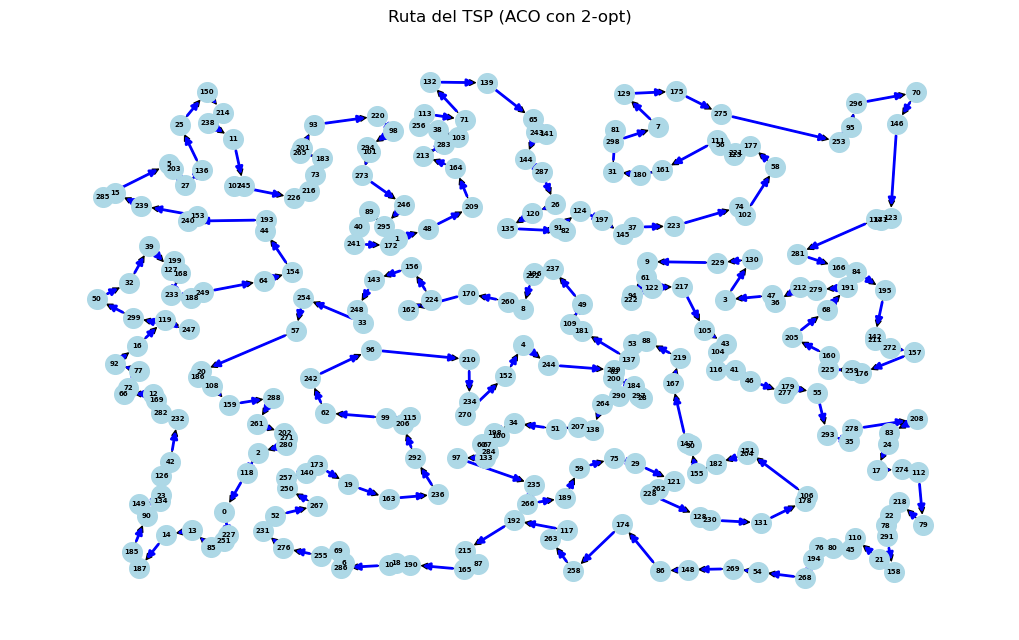

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Graficar resultado utilizando NetworkX
def Graficar(coordenadas, ruta):    
    G = nx.DiGraph()  # Grafo dirigido para la ruta

    # Añadir nodos y sus posiciones
    for i, (x, y) in enumerate(coordenadas):
        G.add_node(i, pos=(x, y))

    # Añadir aristas según la ruta
    for i in range(len(ruta) - 1):
        G.add_edge(ruta[i], ruta[i + 1])

    # Extraer posiciones para la visualización
    pos = nx.get_node_attributes(G, 'pos')

    # Dibujar el grafo
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightblue', font_size=5, font_weight='bold')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges, edge_color='blue', width=2, arrows=True)
    plt.title("Ruta del TSP (ACO con 2-opt)")
    plt.grid(True)
    plt.show()

Graficar(coordenadas, ruta)

In [ ]:
archivo_matriz = 'TSP\Distancia.txt'
archivo_coordenadas = 'TSP\Coordenadas.txt'

# Leer archivos
matriz_distancias = leer_matriz_distancias(archivo_matriz)
coordenadas = leer_coordenadas(archivo_coordenadas)

In [ ]:
pd.DataFrame(matriz_distancias)

0        1         2        3        4        5         6    \
0      0.0000  58.3867   12.4185  73.8024  49.1522  69.8627   17.6958   
1     58.3867   0.0000   45.9783  41.3960  26.0367  31.3690   65.0921   
2     12.4185  45.9783    0.0000  64.1829  38.6700  58.7757   24.3302   
3     73.8024  41.3960   64.1829   0.0000  25.9644  72.4060   69.8825   
4     49.1522  26.0367   38.6700  25.9644   0.0000  55.9821   48.7051   
..        ...      ...       ...      ...      ...      ...       ...   
295   60.2830   2.9988   47.8646  43.6728  29.0263  28.8236   67.5220   
296  111.6961  61.6461  100.4924  42.3328  62.7754  83.7883  110.7308   
297   55.1275  42.8233   47.3972  21.8368  17.3010  73.2510   48.8164   
298   87.6220  32.5317   75.6017  34.3880  42.0278  53.7973   90.2875   
299   40.3239  35.4857   30.9247  71.4688  47.3257  31.0284   55.2277   

         7        8        9    ...      290       291      292      293  \
0    93.1051  54.2284  71.4491  ...  52.9441   80.0614  25.3908  74.3581   
1    38.7006  20.6480  30.4988  ...  41.2991   83.8390  43.9067  65.0275   
2    81.1969  43.0447  60.6099  ...  45.0721   77.7089  19.0447  68.8301   
3    35.5095  24.4667  12.1225  ...  23.1306   51.2047  49.0149  29.6991   
4    46.5253   7.1306  22.3604  ...  15.4973   58.2697  26.1873  40.8905   
..       ...      ...      ...  ...      ...       ...      ...      ...   
295  38.5845  23.5411  32.4885  ...  44.2600   86.7542  46.5727  67.8179   
296  24.2802  57.4989  40.4409  ...  65.1544   86.7093  88.6850  66.3857   
297  53.8395  22.2909  26.8629  ...   2.3805   41.0614  29.7367  24.0440   
298   6.2238  35.1979  24.3266  ...  50.9064   85.5909  67.6736  64.0823   
299  73.9524  47.0142  62.9793  ...  60.6633  100.8613  44.1166  86.9328   

         294      295       296      297      298      299  
0    74.9279  60.2830  111.6961  55.1275  87.6220  40.3239  
1    18.7170   2.9988   61.6461  42.8233  32.5317  35.4857  
2    62.5792  47.8646  100.4924  47.3972  75.6017  30.9247  
3    52.8545  43.6728   42.3328  21.8368  34.3880  71.4688  
4    43.7441  29.0263   62.7754  17.3010  42.0278  47.3257  
..       ...      ...       ...      ...      ...      ...  
295  15.9315   0.0000   61.9735  45.7614  32.3679  35.3680  
296  59.5805  61.9735    0.0000  64.0753  30.2789  97.1316  
297  59.5388  45.7614   64.0753   0.0000  50.9177  62.9450  
298  29.6593  32.3679   30.2789  50.9177   0.0000  67.7357  
299  44.2734  35.3680   97.1316  62.9450  67.7357   0.0000  

[300 rows x 300 columns]

In [ ]:
class ACO:
    def __init__(self, matriz_distancias, num_hormigas, num_iteraciones, alpha=1.0, beta=5.0, rho=0.5, q=100, elitismo=0.1, evaporacion_global=0.1, ruta_inicial=None):
        self.matriz_distancias = matriz_distancias
        self.num_ciudades = matriz_distancias.shape[0]
        self.num_hormigas = num_hormigas
        self.num_iteraciones = num_iteraciones
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.elitismo = elitismo
        self.evaporacion_global = evaporacion_global
        self.feromonas = np.ones((self.num_ciudades, self.num_ciudades)) / self.num_ciudades
        self.ruta_inicial = ruta_inicial  # Ruta inicial opcional

    def _calcular_probabilidades(self, ciudad_actual, no_visitadas):
        feromonas = self.feromonas[ciudad_actual][no_visitadas]
        visibilidad = 1 / self.matriz_distancias[ciudad_actual][no_visitadas]
        probabilidades = (feromonas ** self.alpha) * (visibilidad ** self.beta)
        return probabilidades / probabilidades.sum()

    def _actualizar_feromonas(self, rutas, costes, mejor_ruta_global):
        self.feromonas *= (1 - self.evaporacion_global)
        mejor_coste_global = float('inf')
        for ruta, coste in zip(rutas, costes):
            if coste < mejor_coste_global:
                mejor_coste_global = coste
                mejor_ruta_global = ruta
        for i in range(len(mejor_ruta_global) - 1):
            ciudad_actual = mejor_ruta_global[i]
            siguiente_ciudad = mejor_ruta_global[i + 1]
            self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / mejor_coste_global
            self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / mejor_coste_global
        for ruta, coste in zip(rutas, costes):
            for i in range(len(ruta) - 1):
                ciudad_actual = ruta[i]
                siguiente_ciudad = ruta[i + 1]
                self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / coste
                self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / coste

    def resolver(self, tiempo_limite):
        mejor_ruta_global = None
        mejor_coste_global = float('inf')
        inicio_tiempo = time.time()

        # Si se proporciona una ruta inicial, se puede utilizar para las hormigas
        if self.ruta_inicial:
            mejor_ruta_global = self.ruta_inicial
            mejor_coste_global = sum(self.matriz_distancias[mejor_ruta_global[i], mejor_ruta_global[i + 1]] for i in range(len(mejor_ruta_global) - 1))

        for _ in range(self.num_iteraciones):
            if time.time() - inicio_tiempo > tiempo_limite:
                break

            rutas = []
            costes = []
            for _ in range(self.num_hormigas):
                if self.ruta_inicial:  # Si tenemos ruta inicial, las hormigas comienzan con ella
                    ruta = self.ruta_inicial
                else:
                    ruta = [np.random.randint(self.num_ciudades)]
                    for _ in range(self.num_ciudades - 1):
                        ciudad_actual = ruta[-1]
                        no_visitadas = list(set(range(self.num_ciudades)) - set(ruta))
                        probabilidades = self._calcular_probabilidades(ciudad_actual, no_visitadas)
                        siguiente_ciudad = np.random.choice(no_visitadas, p=probabilidades)
                        ruta.append(siguiente_ciudad)
                ruta.append(ruta[0])  # Volver al inicio
                # Aplicar 2-opt
                ruta = dos_opt(ruta, self.matriz_distancias)  # Aplicar 2-opt
                rutas.append(ruta)
                coste = sum(self.matriz_distancias[ruta[i], ruta[i + 1]] for i in range(len(ruta) - 1))
                costes.append(coste)

            self._actualizar_feromonas(rutas, costes, mejor_ruta_global)
            for ruta, coste in zip(rutas, costes):
                if coste < mejor_coste_global:
                    mejor_coste_global = coste
                    mejor_ruta_global = ruta

        return mejor_ruta_global, mejor_coste_global


# Ejecutar el algoritmo de Christofides para obtener una ruta inicial
matriz_distancias = leer_matriz_distancias('Distancia.txt')

G = nx.Graph()
for i in range(len(matriz_distancias)):
    for j in range(i+1, len(matriz_distancias[i])):
        G.add_edge(i, j, weight=matriz_distancias[i][j])

# Ejecutar el algoritmo de Christofides
ruta_christofides = christofides_tsp(G)

# Configurar y ejecutar ACO con la ruta inicial de Christofides
num_hormigas = 25
num_iteraciones = 100
tiempo_limite = 110  # Límite de tiempo en segundos

aco = ACO(matriz_distancias, num_hormigas, num_iteraciones, ruta_inicial=ruta_christofides)
ruta, coste = aco.resolver(tiempo_limite)

# Mostrar resultados
print(f'\nCosto de la mejor ruta: {coste}')
print(f'Ruta: {ruta}')


Costo de la mejor ruta: 1443.8956999999998
Ruta: [0, 231, 276, 255, 69, 6, 286, 10, 18, 190, 165, 87, 215, 258, 263, 117, 192, 266, 235, 189, 59, 174, 228, 262, 121, 155, 128, 230, 178, 106, 131, 86, 148, 269, 54, 268, 194, 76, 80, 45, 110, 158, 21, 291, 78, 22, 79, 218, 112, 274, 17, 24, 83, 208, 278, 35, 293, 55, 277, 179, 205, 160, 225, 259, 176, 157, 272, 211, 142, 195, 84, 166, 191, 68, 279, 212, 47, 36, 3, 104, 43, 105, 217, 122, 222, 94, 61, 9, 223, 37, 145, 197, 124, 91, 82, 120, 26, 287, 144, 81, 298, 31, 180, 161, 74, 102, 229, 130, 281, 114, 171, 123, 146, 70, 296, 95, 253, 58, 177, 221, 125, 56, 111, 7, 275, 175, 129, 141, 65, 243, 71, 139, 132, 113, 256, 98, 220, 101, 294, 93, 201, 265, 183, 73, 216, 226, 193, 44, 245, 107, 136, 11, 214, 150, 238, 25, 203, 5, 27, 285, 15, 239, 153, 240, 39, 199, 127, 168, 32, 50, 233, 249, 188, 64, 154, 241, 172, 1, 48, 246, 295, 40, 89, 273, 213, 283, 38, 103, 164, 209, 135, 237, 49, 181, 53, 88, 137, 289, 63, 200, 184, 167, 219, 116, 41

In [ ]:
import networkx as nx
from itertools import cycle

def christofides_tsp(G):
    # Paso 1: Construir el árbol de expansión mínima
    T = nx.minimum_spanning_tree(G)
    
    # Paso 2: Identificar los vértices con grado impar
    odd_degree_nodes = {node for node, degree in T.degree() if degree % 2 == 1}
    
    # Paso 3: Encontrar un emparejamiento perfecto mínimo ponderado
    M = nx.max_weight_matching(nx.Graph(T.subgraph(odd_degree_nodes)), maxcardinality=True)
    
    # Paso 4: Combinar el árbol y el emparejamiento
    multigraph = nx.MultiGraph()
    multigraph.add_edges_from(T.edges())
    
    # Agregar los bordes del emparejamiento al multigrafo
    for u, v in M:
        multigraph.add_edge(u, v)
    
    # Asegurar que el grafo sea euleriano
    while not nx.is_eulerian(multigraph):
        # Encontrar dos vértices con grado impar
        odd_vertices = [v for v, deg in multigraph.degree() if deg % 2 != 0]
        
        # Añadir un nuevo borde entre ellos
        multigraph.add_edge(*odd_vertices[:2])
    
    # Paso 5: Construir un circuito euleriano
    eulerian_circuit = list(nx.eulerian_circuit(multigraph))
    
    # Paso 6: Convertir el circuito euleriano a una ruta hamiltoniana
    route = []
    seen = set()
    for edge in eulerian_circuit:
        if edge[0] not in seen:
            route.append(edge[0])
            seen.add(edge[0])
        if edge[1] not in seen:
            route.append(edge[1])
            seen.add(edge[1])
    
    # Agregar el último vértice al inicio para cerrar la ruta
    route.append(route[0])
    
    return route

matriz_distancias = leer_matriz_distancias('Distancia.txt')

G = nx.Graph()
for i in range(len(matriz_distancias)):
    for j in range(i+1, len(matriz_distancias[i])):
        G.add_edge(i, j, weight=matriz_distancias[i][j])

# Ejecutar el algoritmo de Christofides
ruta_christofides = christofides_tsp(G)

In [ ]:
def calcular_costo_ruta(ruta, G):
    return sum(G[u][v]['weight'] for u, v in zip(ruta, ruta[1:]))

def buscar_mejor_vecino_2opt(ruta, G):
    n = len(ruta)
    mejor_ruta = ruta[:]
    mejor_costo = calcular_costo_ruta(ruta, G)
    
    for i in range(1, n - 2):
        for j in range(i + 1, n - 1):
            # Generar nueva ruta intercambiando dos segmentos
            nueva_ruta = ruta[:i] + ruta[i:j][::-1] + ruta[j:]
            nuevo_costo = calcular_costo_ruta(nueva_ruta, G)
            
            if nuevo_costo < mejor_costo:
                mejor_ruta = nueva_ruta
                mejor_costo = nuevo_costo
    
    return mejor_ruta, mejor_costo

def busqueda_local_2opt(ruta_inicial, G, limite_tiempo=60):
    inicio = time.time()
    ruta_actual = ruta_inicial
    mejor_costo = calcular_costo_ruta(ruta_actual, G)
    
    while time.time() - inicio < limite_tiempo:
        nueva_ruta, nuevo_costo = buscar_mejor_vecino_2opt(ruta_actual, G)
        if nuevo_costo < mejor_costo:
            ruta_actual = nueva_ruta
            mejor_costo = nuevo_costo
        else:
            break  # Detener si no hay mejora
    
    return ruta_actual, mejor_costo

In [ ]:
def buscar_mejor_vecino_3opt(ruta, G):
    n = len(ruta) // 5
    mejor_ruta = ruta[:]
    mejor_costo = calcular_costo_ruta(ruta, G)
    
    # Generar todas las combinaciones posibles de tres cortes en la ruta
    for i in range(1, n - 3):
        for j in range(i + 1, n - 2):
            for k in range(j + 1, n - 1):
                # Generar las 7 posibles reconexiones para 3-opt
                nuevas_rutas = [
                    ruta[:i] + ruta[i:j][::-1] + ruta[j:k][::-1] + ruta[k:],  # Invertir ambos segmentos internos
                    ruta[:i] + ruta[j:k] + ruta[i:j] + ruta[k:],              # Intercambiar segmentos
                    ruta[:i] + ruta[j:k][::-1] + ruta[i:j] + ruta[k:],        # Invertir uno de los segmentos
                    ruta[:i] + ruta[i:j] + ruta[k - 1:j - 1:-1] + ruta[k:],  # Reorganizar segmentos (otra forma)
                    ruta[:i] + ruta[k - 1:j - 1:-1] + ruta[i:j][::-1] + ruta[k:],  # Más combinaciones
                    # Las combinaciones restantes dependerán de los cortes, pero suelen ser 7 en total
                ]
                
                # Evaluar todas las rutas generadas
                for nueva_ruta in nuevas_rutas:
                    nuevo_costo = calcular_costo_ruta(nueva_ruta, G)
                    if nuevo_costo < mejor_costo:
                        mejor_ruta = nueva_ruta
                        mejor_costo = nuevo_costo

    return mejor_ruta, mejor_costo

def busqueda_local_3opt_tiempo(ruta_inicial, G, limite_tiempo=60):
    inicio = time.time()
    ruta_actual = ruta_inicial
    mejor_costo = calcular_costo_ruta(ruta_actual, G)
    
    while time.time() - inicio < limite_tiempo:
        nueva_ruta, nuevo_costo = buscar_mejor_vecino_3opt(ruta_actual, G)
        if nuevo_costo < mejor_costo:
            ruta_actual = nueva_ruta
            mejor_costo = nuevo_costo
        else:
            break  # Detener si no hay mejora
    
    return ruta_actual, mejor_costo

In [ ]:
def simulated_annealing(ruta_inicial, G, temperatura_inicial=1000, enfriamiento=0.998, limite_tiempo=60):
    inicio = time.time()
    ruta_actual = ruta_inicial[:]
    mejor_ruta = ruta_actual[:]
    mejor_costo = calcular_costo_ruta(ruta_actual, G)
    temperatura = temperatura_inicial
    
    while time.time() - inicio < limite_tiempo:
        # Crear una solución vecina aleatoria (intercambiar dos nodos)
        i, j = sorted(random.sample(range(1, len(ruta_actual) - 1), 2))
        nueva_ruta = ruta_actual[:i] + ruta_actual[i:j][::-1] + ruta_actual[j:]
        nuevo_costo = calcular_costo_ruta(nueva_ruta, G)
        
        # Decidir si aceptar la solución
        delta = nuevo_costo - mejor_costo
        if delta < 0 or random.random() < math.exp(-delta / temperatura):
            ruta_actual = nueva_ruta
            mejor_costo = nuevo_costo
            mejor_ruta = nueva_ruta if nuevo_costo < mejor_costo else mejor_ruta
        
        # Enfriar la temperatura
        temperatura *= enfriamiento
        if temperatura < 1e-3:
            break  # Detener si la temperatura es demasiado baja
    
    return mejor_ruta, mejor_costo

In [ ]:
def nearest_neighbour(G, nodo_inicial=0):
    """
    Algoritmo Nearest Neighbour para el TSP.
    
    :param G: Grafo completo con distancias como pesos de las aristas.
    :param nodo_inicial: Nodo desde el cual comienza el recorrido.
    :return: Una lista con la ruta aproximada y su costo total.
    """
    # Inicializar variables
    ruta = [nodo_inicial]
    costo_total = 0
    nodos_visitados = set(ruta)
    
    # Recorrer hasta visitar todos los nodos
    while len(ruta) < len(G.nodes):
        nodo_actual = ruta[-1]
        # Buscar el nodo no visitado más cercano
        vecino_mas_cercano, distancia_minima = min(
            ((vecino, datos['weight']) for vecino, datos in G[nodo_actual].items() if vecino not in nodos_visitados),
            key=lambda x: x[1]
        )
        # Añadir el nodo más cercano a la ruta
        ruta.append(vecino_mas_cercano)
        nodos_visitados.add(vecino_mas_cercano)
        costo_total += distancia_minima
    
    # Regresar al nodo inicial para cerrar el ciclo
    costo_total += G[ruta[-1]][nodo_inicial]['weight']
    ruta.append(nodo_inicial)
    
    return ruta, costo_total


In [ ]:
# Elegir un nodo inicial (opcionalmente se puede probar con varios para comparar resultados)
nodo_inicial = 0

# Ejecutar el algoritmo Nearest Neighbour
ruta_nn, costo_nn = nearest_neighbour(G, nodo_inicial=nodo_inicial)

print("Ruta obtenida (Nearest Neighbour):", ruta_nn)
print("Costo total (Nearest Neighbour):", costo_nn)

Ruta obtenida (Nearest Neighbour): [0, 227, 251, 85, 13, 14, 90, 149, 134, 23, 126, 42, 232, 282, 169, 12, 72, 66, 77, 92, 16, 299, 119, 247, 188, 249, 233, 168, 127, 199, 39, 240, 153, 27, 203, 5, 136, 107, 245, 226, 216, 73, 183, 265, 201, 93, 220, 98, 256, 38, 103, 283, 213, 164, 209, 135, 120, 26, 124, 197, 145, 37, 223, 9, 61, 122, 94, 222, 49, 109, 181, 53, 88, 137, 289, 63, 200, 184, 297, 28, 290, 264, 138, 207, 51, 34, 198, 100, 67, 60, 284, 133, 97, 292, 206, 115, 99, 62, 202, 271, 280, 2, 118, 257, 250, 140, 173, 19, 163, 236, 192, 266, 235, 189, 59, 75, 29, 262, 228, 121, 155, 182, 204, 151, 30, 147, 167, 219, 104, 43, 105, 3, 47, 36, 212, 279, 191, 84, 166, 281, 130, 229, 217, 237, 196, 252, 260, 8, 4, 244, 152, 210, 234, 270, 96, 33, 248, 162, 224, 170, 156, 172, 1, 295, 40, 89, 246, 48, 241, 143, 254, 154, 64, 44, 193, 273, 101, 294, 113, 71, 139, 132, 65, 243, 141, 144, 287, 31, 180, 161, 298, 81, 7, 175, 129, 275, 111, 56, 221, 125, 177, 58, 74, 102, 114, 171, 123, 195,

In [ ]:
# Ruta inicial con Christofides
ruta_christofides = christofides_tsp(G)

# Mejorar con búsqueda local (2-opt)
ruta_mejorada, costo_mejorado = busqueda_local_2opt(ruta_christofides, G, limite_tiempo=120)

# O mejorar con Simulated Annealing
#ruta_annealing, costo_annealing = simulated_annealing(ruta_christofides, G, limite_tiempo=10)

# Mejorar con búsqueda local (3-opt)
#ruta_mejorada_3opt, costo_mejorado_3opt = busqueda_local_3opt_tiempo(ruta_christofides, G, limite_tiempo=10)

print("Ruta mejorada (2-opt):", ruta_mejorada)
print("Costo mejorado (2-opt):", costo_mejorado)

# print("Ruta mejorada (3-opt):", ruta_mejorada_3opt)
# print("Costo mejorado (3-opt):", costo_mejorado_3opt)

# print("Ruta mejorada (Simulated Annealing):", ruta_annealing)
# print("Costo mejorado (Simulated Annealing):", costo_annealing)


Ruta mejorada (2-opt): [0, 227, 231, 276, 255, 69, 6, 286, 10, 18, 190, 165, 87, 215, 52, 267, 250, 257, 140, 173, 19, 163, 236, 187, 185, 14, 285, 15, 239, 153, 27, 5, 4, 244, 152, 210, 234, 270, 198, 115, 206, 99, 292, 97, 133, 284, 67, 60, 100, 34, 51, 207, 138, 75, 264, 290, 297, 184, 200, 63, 289, 137, 53, 88, 55, 278, 35, 293, 36, 47, 212, 279, 68, 191, 195, 84, 166, 281, 130, 229, 123, 171, 114, 102, 74, 223, 37, 145, 197, 124, 26, 120, 135, 209, 139, 132, 113, 256, 7, 81, 129, 175, 275, 111, 56, 125, 221, 177, 58, 253, 296, 95, 146, 70, 142, 211, 272, 157, 176, 259, 225, 160, 205, 151, 204, 182, 147, 30, 155, 121, 262, 228, 86, 148, 269, 54, 268, 194, 76, 80, 45, 158, 21, 110, 291, 78, 22, 79, 218, 112, 274, 17, 24, 83, 208, 179, 277, 46, 41, 116, 106, 178, 131, 230, 128, 29, 59, 189, 235, 266, 192, 258, 263, 117, 174, 118, 2, 280, 271, 62, 202, 261, 159, 108, 186, 12, 66, 72, 77, 92, 16, 299, 247, 119, 32, 50, 240, 39, 199, 127, 168, 233, 188, 249, 226, 216, 273, 73, 183, 265,

Ruta de Christofides: [0, 227, 231, 276, 255, 69, 6, 286, 10, 18, 190, 165, 87, 215, 93, 201, 265, 183, 73, 273, 216, 226, 249, 188, 233, 168, 127, 199, 39, 240, 256, 113, 132, 139, 209, 135, 120, 26, 124, 197, 145, 37, 223, 74, 102, 82, 91, 287, 144, 243, 65, 141, 298, 31, 180, 161, 236, 163, 19, 173, 140, 257, 250, 267, 52, 44, 193, 245, 107, 136, 203, 11, 238, 25, 214, 150, 142, 211, 272, 157, 176, 259, 225, 160, 205, 151, 204, 182, 147, 30, 155, 121, 262, 228, 237, 196, 252, 260, 9, 61, 122, 57, 254, 248, 143, 156, 172, 1, 48, 295, 40, 241, 89, 246, 101, 294, 98, 220, 38, 103, 71, 283, 213, 164, 187, 185, 14, 285, 15, 239, 153, 27, 5, 4, 244, 152, 210, 234, 270, 198, 115, 206, 99, 292, 97, 133, 284, 67, 60, 100, 34, 51, 207, 138, 75, 264, 290, 297, 184, 200, 63, 289, 137, 53, 88, 55, 278, 35, 293, 36, 47, 212, 279, 68, 191, 195, 84, 166, 281, 130, 229, 123, 171, 114, 86, 148, 269, 54, 268, 194, 76, 80, 45, 28, 167, 219, 104, 43, 105, 3, 217, 94, 222, 49, 109, 181, 8, 170, 224, 162,

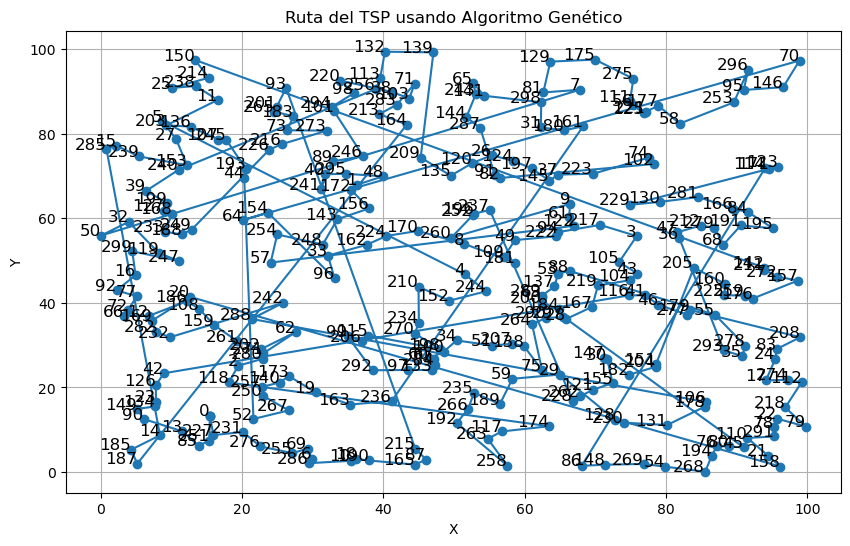

In [ ]:
costo_christofides = sum(matriz_distancias[ruta_christofides[i], ruta_christofides[i + 1]] for i in range(len(ruta_christofides) - 1))
print(f'Ruta de Christofides: {ruta_christofides}')
print(f'Costo de Christofides: {costo_christofides}')
mostrar_resultado(coordenadas, ruta_christofides)

In [ ]:
#Ahora intentar el algoritmo de christofides
    
def vecino_mas_cercano(matriz_distancias):
    matriz_distancias = pd.DataFrame(matriz_distancias)
    num_ciudades = matriz_distancias.shape[0]
    visitadas = [False] * num_ciudades
    ruta = [0]
    visitadas[0] = True
    for _ in range(num_ciudades - 1):
        ciudad_actual = ruta[-1]
        ciudad_mas_cercana = None
        distancia_mas_cercana = float('inf')
        for vecino in range(num_ciudades):
            if not visitadas[vecino] and matriz_distancias[ciudad_actual, vecino] < distancia_mas_cercana:
                ciudad_mas_cercana = vecino
                distancia_mas_cercana = matriz_distancias[ciudad_actual, vecino]
        ruta.append(ciudad_mas_cercana)
        visitadas[ciudad_mas_cercana] = True
    return ruta

def algoritmo_christofides(matriz_distancias):
    # Paso 1: Obtener un emparejamiento perfecto mínimo
    emparejamiento = emparejamiento_minimo(matriz_distancias)
    
    # Paso 2: Construir un grafo con los nodos de grado impar del emparejamiento
    nodos_impares = nodos_de_grado_impar(emparejamiento)
    grafo = grafo_nodos_impares(nodos_impares, matriz_distancias)
    
    # Paso 3: Encontrar un emparejamiento perfecto mínimo en el grafo
    emparejamiento = emparejamiento_minimo(grafo)
    
    # Paso 4: Combinar los emparejamientos
    emparejamiento_final = emparejamiento + emparejamiento
    
    # Paso 5: Encontrar un circuito euleriano
    circuito_euleriano = circuito_euleriano_grafo(emparejamiento_final)
    
    # Paso 6: Obtener la ruta final
    ruta = ruta_christofides(circuito_euleriano, matriz_distancias)
    
    return ruta

def emparejamiento_minimo(matriz_distancias):
    num_ciudades = matriz_distancias.shape[0]
    emparejamiento = []
    visitados = [False] * num_ciudades
    for i in range(num_ciudades):
        if not visitados[i]:
            vecino_mas_cercano = None
            distancia_mas_cercana = float('inf')
            for j in range(i + 1, num_ciudades):
                if not visitados[j] and matriz_distancias[i, j] < distancia_mas_cercana:
                    vecino_mas_cercano = j
                    distancia_mas_cercana = matriz_distancias[i, j]
            emparejamiento.append((i, vecino_mas_cercano))
            visitados[i] = True
            visitados[vecino_mas_cercano] = True
    return emparejamiento

def nodos_de_grado_impar(emparejamiento):
    
    nodos = set()
    for arista in emparejamiento:
        nodos.add(arista[0])
        nodos.add(arista[1])
    
    grado = {nodo: 0 for nodo in nodos}
    for arista in emparejamiento:
        grado[arista[0]] += 1
        grado[arista[1]] += 1
    
    nodos_impares = [nodo for nodo in nodos if grado[nodo] % 2 == 1]
    
    return nodos_impares

def grafo_nodos_impares(nodos_impares, matriz_distancias):
    
    num_nodos = len(nodos_impares)
    grafo = np.zeros((num_nodos, num_nodos))
    for i in range(num_nodos):
        for j in range(i + 1, num_nodos):
            grafo[i, j] = matriz_distancias[nodos_impares[i], nodos_impares[j]]
            grafo[j, i] = grafo[i, j]
    
    return grafo

def circuito_euleriano_grafo(matriz_distancias):    
    num_nodos = matriz_distancias.shape[0]
    grafo = nx.Graph()
    for i in range(num_nodos):
        for j in range(i + 1, num_nodos):
            grafo.add_edge(i, j, weight=matriz_distancias[i, j])    
    circuito_euleriano = list(nx.eulerian_circuit(grafo))
    
    return circuito_euleriano

def ruta_christofides(circuito_euleriano, matriz_distancias):
    
    ruta = []
    visitados = [False] * matriz_distancias.shape[0]
    for arista in circuito_euleriano:
        if not visitados[arista[0]]:
            ruta.append(arista[0])
            visitados[arista[0]] = True
        if not visitados[arista[1]]:
            ruta.append(arista[1])
            visitados[arista[1]] = True
            
    ruta.append(ruta[0])
    
    return ruta

if __name__ == "__main__":
    # Archivos de entrada
    archivo_matriz = 'Distancia.txt'
    archivo_coordenadas = 'Coordenadas.txt'

    # Leer archivos
    coordenadas = leer_coordenadas(archivo_coordenadas)
    matriz_distancias = matriz_distancias(coordenadas)

    # Resolver TSP con vecino más cercano
    ruta_vecino_mas_cercano = vecino_mas_cercano(matriz_distancias)
    costo_vecino_mas_cercano = sum(matriz_distancias[ruta_vecino_mas_cercano[i], ruta_vecino_mas_cercano[i + 1]] for i in range(len(ruta_vecino_mas_cercano) - 1))
    print(f'Ruta del vecino más cercano: {ruta_vecino_mas_cercano}')
    print(f'Costo del vecino más cercano: {costo_vecino_mas_cercano}')
    mostrar_resultado(coordenadas, ruta_vecino_mas_cercano)

    # Resolver TSP con algoritmo de Christofides
    ruta_christofides = algoritmo_christofides(matriz_distancias)
    costo_christofides = sum(matriz_distancias[ruta_christofides[i], ruta_christofides[i + 1]] for i in range(len(ruta_christofides) - 1))
    print(f'Ruta de Christofides: {ruta_christofides}')
    print(f'Costo de Christofides: {costo_christofides}')
    mostrar_resultado(coordenadas, ruta_christofides)



KeyError: (0, 1)

In [ ]:
import random
import math
import copy

class CLKH:
    def __init__(self, distancia_matrix, num_ciudades, max_iteraciones=10000, max_sin_mejorar=5000):
        self.distancia_matrix = distancia_matrix
        self.num_ciudades = num_ciudades
        self.max_iteraciones = max_iteraciones
        self.max_sin_mejorar = max_sin_mejorar
        
        # Inicializa la mejor ruta y su costo
        self.mejor_ruta = None
        self.mejor_costo = float('inf')

    def generar_ruta_aleatoria(self):
        ruta = list(range(self.num_ciudades))
        random.shuffle(ruta)
        return ruta

    def calcular_costo(self, ruta):
        costo = sum([self.distancia_matrix[ruta[i]][ruta[(i+1)%self.num_ciudades]] for i in range(self.num_ciudades)])
        return costo

    def lin_kernighan(self, ruta):
        mejor_ruta = ruta[:]
        mejor_costo = self.calcular_costo(mejor_ruta)
        sin_mejorar = 0

        while sin_mejorar < self.max_sin_mejorar:
            for i in range(self.num_ciudades - 1):
                for k in range(i + 1, self.num_ciudades):
                    nueva_ruta = self.intercambiar_segmentos(mejor_ruta, i, k)
                    nuevo_costo = self.calcular_costo(nueva_ruta)

                    if nuevo_costo < mejor_costo:
                        mejor_ruta = nueva_ruta
                        mejor_costo = nuevo_costo
                        sin_mejorar = 0
                        break
                else:
                    continue
                break
            else:
                sin_mejorar += 1

        return mejor_ruta, mejor_costo

    def intercambiar_segmentos(self, ruta, i, k):
        return ruta[:i] + list(reversed(ruta[i:k])) + ruta[k:]

    def chained_lin_kernighan(self):
        mejor_ruta = self.generar_ruta_aleatoria()
        mejor_costo = self.calcular_costo(mejor_ruta)

        iteracion = 0
        while iteracion < self.max_iteraciones:
            nueva_ruta, nuevo_costo = self.lin_kernighan(mejor_ruta)

            if nuevo_costo < mejor_costo:
                mejor_ruta = nueva_ruta
                mejor_costo = nuevo_costo
                self.mejor_ruta = mejor_ruta
                self.mejor_costo = mejor_costo
            else:
                # Aplicar una perturbación aleatoria
                mejor_ruta = self.perturbar_ruta(mejor_ruta)

            iteracion += 1

        return self.mejor_ruta, self.mejor_costo

    def perturbar_ruta(self, ruta):
        num_perturbaciones = random.randint(1, min(5, self.num_ciudades // 2))
        indices = random.sample(range(self.num_ciudades), num_perturbaciones * 2)
        nuevos_indices = random.sample(indices, num_perturbaciones * 2)
        nueva_ruta = ruta[:]
        for i, j in zip(indices[:num_perturbaciones], nuevos_indices[:num_perturbaciones]):
            nueva_ruta[i], nueva_ruta[j] = nueva_ruta[j], nueva_ruta[i]
        return nueva_ruta

# Ejemplo de uso
def ejemplo_uso():
    # Simula una matriz de distancias para 10 ciudades
    num_ciudades = 10
    distancia_matrix = [[random.randint(1, 100) for _ in range(num_ciudades)] for _ in range(num_ciudades)]
    for i in range(num_ciudades):
        distancia_matrix[i][i] = 0
        for j in range(i+1, num_ciudades):
            distancia_matrix[j][i] = distancia_matrix[i][j]

    clk = CLKH(distancia_matrix, num_ciudades)
    mejor_ruta, mejor_costo = clk.chained_lin_kernighan()

    print(f"Mejor ruta encontrada: {mejor_ruta}")
    print(f"Costo de la mejor ruta: {mejor_costo}")

# Ejecutar el ejemplo
ejemplo_uso()


KeyboardInterrupt: 

Mejor ruta encontrada: [119, 188, 249, 57, 254, 64, 154, 44, 193, 226, 216, 73, 265, 201, 93, 183, 273, 89, 40, 241, 295, 102, 170, 95, 63, 258, 297, 112, 164, 220, 177, 56, 55, 162, 79, 292, 24, 286, 271, 250, 257, 251, 0, 231, 86, 140, 19, 269, 51, 34, 178, 244, 4, 96, 152, 179, 33, 248, 234, 28, 3, 217, 180, 21, 59, 131, 53, 196, 228, 17, 129, 103, 113, 229, 48, 61, 36, 10, 84, 204, 143, 156, 209, 38, 256, 120, 272, 219, 181, 210, 207, 291, 97, 83, 142, 175, 116, 147, 88, 278, 195, 158, 133, 6, 69, 267, 128, 198, 206, 200, 225, 146, 94, 91, 9, 144, 176, 279, 260, 252, 76, 145, 70, 296, 114, 123, 161, 298, 101, 294, 213, 246, 135, 26, 47, 46, 78, 182, 218, 171, 65, 275, 139, 167, 137, 222, 237, 124, 283, 191, 81, 98, 74, 68, 221, 184, 125, 130, 104, 274, 35, 215, 293, 263, 62, 270, 67, 284, 148, 205, 253, 151, 266, 117, 190, 100, 255, 189, 52, 227, 185, 276, 2, 13, 149, 126, 14, 282, 66, 72, 12, 169, 232, 23, 134, 118, 280, 202, 99, 194, 174, 208, 30, 289, 122, 109, 29, 110, 37, 105,

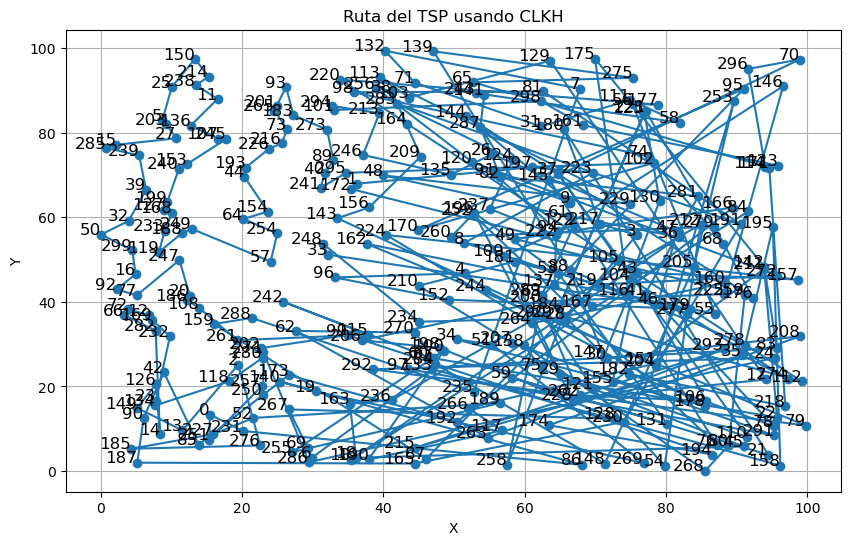

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# Leer matriz de distancias desde un archivo
def leer_matriz_distancias(filename):
    with open(filename, 'r') as file:
        matriz = []
        for line in file:
            fila = list(map(float, line.strip().split()))
            matriz.append(fila)
    return np.array(matriz)

# Leer coordenadas desde un archivo
def leer_coordenadas(filename):
    with open(filename, 'r') as file:
        coordenadas = []
        for line in file:
            x, y = map(float, line.strip().split())
            coordenadas.append((x, y))
    return coordenadas

class CLKH:
    def __init__(self, distancia_matrix, num_ciudades, max_iteraciones=10000, max_sin_mejorar=5000, timeout=120):
        self.distancia_matrix = distancia_matrix
        self.num_ciudades = num_ciudades
        self.max_iteraciones = max_iteraciones
        self.max_sin_mejorar = max_sin_mejorar
        self.timeout = timeout
        
        # Inicializa la mejor ruta y su costo
        self.mejor_ruta = None
        self.mejor_costo = float('inf')
        self.start_time = time.time()

    def generar_ruta_aleatoria(self):
        ruta = list(range(self.num_ciudades))
        random.shuffle(ruta)
        return ruta

    def calcular_costo(self, ruta):
        costo = sum([self.distancia_matrix[ruta[i]][ruta[(i+1)%self.num_ciudades]] for i in range(self.num_ciudades)])
        return costo

    def lin_kernighan(self, ruta):
        mejor_ruta = ruta[:]
        mejor_costo = self.calcular_costo(mejor_ruta)
        sin_mejorar = 0

        while sin_mejorar < self.max_sin_mejorar and time.time() - self.start_time < self.timeout:
            for i in range(self.num_ciudades - 1):
                for k in range(i + 1, self.num_ciudades):
                    nueva_ruta = self.intercambiar_segmentos(mejor_ruta, i, k)
                    nuevo_costo = self.calcular_costo(nueva_ruta)

                    if nuevo_costo < mejor_costo:
                        mejor_ruta = nueva_ruta
                        mejor_costo = nuevo_costo
                        sin_mejorar = 0
                        break
                else:
                    continue
                break
            else:
                sin_mejorar += 1

        return mejor_ruta, mejor_costo

    def intercambiar_segmentos(self, ruta, i, k):
        return ruta[:i] + list(reversed(ruta[i:k])) + ruta[k:]

    def chained_lin_kernighan(self):
        mejor_ruta = self.generar_ruta_aleatoria()
        mejor_costo = self.calcular_costo(mejor_ruta)

        iteracion = 0
        while iteracion < self.max_iteraciones and time.time() - self.start_time < self.timeout:
            nueva_ruta, nuevo_costo = self.lin_kernighan(mejor_ruta)

            if nuevo_costo < mejor_costo:
                mejor_ruta = nueva_ruta
                mejor_costo = nuevo_costo
                self.mejor_ruta = mejor_ruta
                self.mejor_costo = mejor_costo
            else:
                # Aplicar una perturbación aleatoria
                mejor_ruta = self.perturbar_ruta(mejor_ruta)

            iteracion += 1

        return self.mejor_ruta, self.mejor_costo

    def perturbar_ruta(self, ruta):
        num_perturbaciones = random.randint(1, min(5, self.num_ciudades // 2))
        indices = random.sample(range(self.num_ciudades), num_perturbaciones * 2)
        nuevos_indices = random.sample(indices, num_perturbaciones * 2)
        nueva_ruta = ruta[:]
        for i, j in zip(indices[:num_perturbaciones], nuevos_indices[:num_perturbaciones]):
            nueva_ruta[i], nueva_ruta[j] = nueva_ruta[j], nueva_ruta[i]
        return nueva_ruta


def mostrar_resultado(coordenadas, ruta):
    x = [coordenadas[i][0] for i in ruta]
    y = [coordenadas[i][1] for i in ruta]
    plt.figure(figsize=(10, 6))
    plt.plot(x + [x[0]], y + [y[0]], marker='o')
    for i, (xi, yi) in enumerate(coordenadas):
        plt.text(xi, yi, str(i), fontsize=12, ha='right')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Ruta del TSP usando CLKH')
    plt.grid(True)
    plt.show()

archivo_matriz = 'Distancia.txt'
archivo_coordenadas = 'Coordenadas.txt'

# Leer archivos
matriz_distancias = leer_matriz_distancias(archivo_matriz)
coordenadas = leer_coordenadas(archivo_coordenadas)

num_ciudades = len(matriz_distancias)

clk = CLKH(matriz_distancias, num_ciudades, timeout=120)
mejor_ruta, mejor_costo = clk.chained_lin_kernighan()

print(f"Mejor ruta encontrada: {mejor_ruta}")
print(f"Costo de la mejor ruta: {mejor_costo}")

tiempo_ejecucion = time.time() - clk.start_time
print(f"Tiempo de ejecución: {tiempo_ejecucion:.2f} segundos")

mostrar_resultado(coordenadas, mejor_ruta)

Mejor ruta encontrada: [186, 69, 79, 60, 262, 165, 6, 92, 66, 179, 109, 25, 91, 118, 0, 27, 71, 113, 94, 236, 189, 8, 209, 221, 140, 247, 254, 31, 175, 103, 248, 264, 33, 204, 122, 5, 64, 188, 210, 29, 242, 85, 255, 285, 299, 187, 32, 44, 226, 141, 68, 219, 173, 19, 133, 151, 95, 9, 266, 62, 231, 77, 16, 272, 114, 253, 37, 39, 126, 156, 48, 132, 243, 180, 197, 217, 129, 40, 199, 176, 201, 11, 265, 1, 170, 102, 139, 164, 87, 97, 99, 119, 124, 259, 234, 185, 98, 93, 51, 34, 229, 43, 55, 30, 67, 17, 241, 49, 105, 145, 88, 135, 123, 86, 142, 205, 61, 117, 263, 278, 158, 160, 269, 227, 13, 52, 267, 161, 41, 36, 222, 212, 193, 127, 211, 218, 110, 178, 240, 150, 4, 75, 230, 215, 59, 116, 83, 224, 112, 288, 282, 47, 53, 250, 18, 54, 12, 214, 283, 81, 177, 125, 223, 146, 89, 216, 220, 172, 167, 225, 84, 56, 7, 130, 171, 38, 144, 291, 45, 14, 202, 279, 195, 74, 157, 22, 111, 104, 290, 131, 148, 190, 90, 149, 286, 194, 46, 287, 100, 3, 297, 235, 163, 181, 260, 280, 20, 270, 57, 258, 228, 293, 155

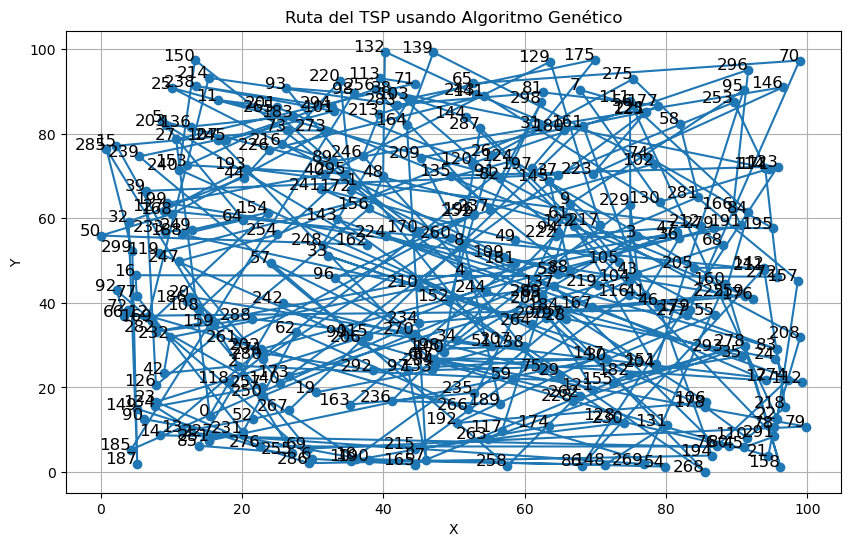

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time

class GeneticAlgorithm:
    def __init__(self, distancia_matrix, poblacion_size=100, generaciones=500, prob_mutacion=0.01, elite_ratio=0.2):
        self.distancia_matrix = distancia_matrix
        self.poblacion_size = poblacion_size
        self.generaciones = generaciones
        self.prob_mutacion = prob_mutacion
        self.elite_ratio = elite_ratio
        
        self.num_ciudades = len(distancia_matrix)
        
        # Inicializa la mejor ruta y su costo
        self.mejor_ruta = None
        self.mejor_costo = float('inf')
        self.start_time = time.time()

    def generar_individuo(self):
        individuo = list(range(self.num_ciudades))
        random.shuffle(individuo)
        return individuo

    def calcular_fitness(self, individuo):
        costo = sum([self.distancia_matrix[individuo[i]][individuo[(i+1)%self.num_ciudades]] for i in range(self.num_ciudades)])
        return 1 / costo  # Usamos el inverso del costo como fitness

    def seleccion(self, poblacion):
        fitness = [self.calcular_fitness(individuo) for individuo in poblacion]
        indices_seleccionados = np.argsort(fitness)[-int(self.poblacion_size * self.elite_ratio):]
        return [poblacion[i] for i in indices_seleccionados]

    def cruza(self, padre1, padre2):
        punto_corte = random.randint(1, self.num_ciudades - 1)
        hijo = [-1] * self.num_ciudades
        
        # Copiar segmento de padre1
        hijo[:punto_corte] = padre1[:punto_corte]
        
        # Rellenar con genes de padre2 que no estén en el segmento copiado
        indice_padre2 = punto_corte
        for i in range(punto_corte, self.num_ciudades):
            while padre2[indice_padre2] in hijo:
                indice_padre2 = (indice_padre2 + 1) % self.num_ciudades
            hijo[i] = padre2[indice_padre2]
        
        return hijo

    def mutacion(self, individuo):
        if random.random() < self.prob_mutacion:
            i, j = random.sample(range(self.num_ciudades), 2)
            individuo[i], individuo[j] = individuo[j], individuo[i]
        return individuo

    def genetic_algorithm(self):
        poblacion = [self.generar_individuo() for _ in range(self.poblacion_size)]
        
        for gen in range(self.generaciones):
            if time.time() - self.start_time > 120:  # Detener después de 2 minutos
                break
            
            # Seleccionar padres
            padres = self.seleccion(poblacion)
            
            # Cruce y mutación para crear nueva población
            nueva_poblacion = []
            while len(nueva_poblacion) < self.poblacion_size:
                padre1, padre2 = random.sample(padres, 2)
                hijo = self.cruza(padre1, padre2)
                hijo_mutado = self.mutacion(hijo)
                nueva_poblacion.append(hijo_mutado)
            
            poblacion = nueva_poblacion
            
            # Actualizar mejor ruta si es necesario
            mejor_individuo = max(poblacion, key=self.calcular_fitness)
            mejor_costo_actual = sum([self.distancia_matrix[mejor_individuo[i]][mejor_individuo[(i+1)%self.num_ciudades]] for i in range(self.num_ciudades)])
            
            if mejor_costo_actual < self.mejor_costo:
                self.mejor_ruta = mejor_individuo
                self.mejor_costo = mejor_costo_actual
        
        return self.mejor_ruta, self.mejor_costo

# Leer matriz de distancias desde un archivo
def leer_matriz_distancias(filename):
    with open(filename, 'r') as file:
        matriz = []
        for line in file:
            fila = list(map(float, line.strip().split()))
            matriz.append(fila)
    return np.array(matriz)

# Leer coordenadas desde un archivo
def leer_coordenadas(filename):
    with open(filename, 'r') as file:
        coordenadas = []
        for line in file:
            x, y = map(float, line.strip().split())
            coordenadas.append((x, y))
    return coordenadas

def mostrar_resultado(coordenadas, ruta):
    x = [coordenadas[i][0] for i in ruta]
    y = [coordenadas[i][1] for i in ruta]
    plt.figure(figsize=(10, 6))
    plt.plot(x + [x[0]], y + [y[0]], marker='o')
    for i, (xi, yi) in enumerate(coordenadas):
        plt.text(xi, yi, str(i), fontsize=12, ha='right')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Ruta del TSP usando Algoritmo Genético')
    plt.grid(True)
    plt.show()

# Ejecución del algoritmo
archivo_matriz = 'Distancia.txt'
archivo_coordenadas = 'Coordenadas.txt'

# Leer archivos
matriz_distancias = leer_matriz_distancias(archivo_matriz)
coordenadas = leer_coordenadas(archivo_coordenadas)

ga = GeneticAlgorithm(matriz_distancias)
mejor_ruta, mejor_costo = ga.genetic_algorithm()

print(f"Mejor ruta encontrada: {mejor_ruta}")
print(f"Costo de la mejor ruta: {mejor_costo}")

tiempo_ejecucion = time.time() - ga.start_time
print(f"Tiempo de ejecución: {tiempo_ejecucion:.2f} segundos")

mostrar_resultado(coordenadas, mejor_ruta)


In [ ]:
#Hacer un diccionario con el numero de la ciudad y sus posiciones

coordenadas = leer_coordenadas(archivo_coordenadas)
ciudades = {i: coord for i, coord in enumerate(coordenadas)}
ciudades

{0: (15.4288, 13.37),
 1: (36.2685, 67.9109),
 2: (19.445, 25.121),
 3: (75.8416, 55.7619),
 4: (51.4803, 46.78),
 5: (8.7176, 82.9095),
 6: (29.8641, 3.1346),
 7: (67.8006, 90.3489),
 8: (51.4451, 53.9105),
 9: (66.4328, 63.4057),
 10: (35.3419, 2.6643),
 11: (16.529, 87.9319),
 12: (6.782, 36.9086),
 13: (11.5501, 9.6294),
 14: (8.377, 8.6927),
 15: (2.2256, 77.1043),
 16: (4.9213, 46.5223),
 17: (94.1233, 21.6512),
 18: (36.1318, 3.1319),
 19: (30.4045, 18.8268),
 20: (12.616, 41.4217),
 21: (94.4671, 3.8344),
 22: (95.704, 12.6316),
 23: (7.7948, 16.6083),
 24: (95.4768, 26.8061),
 25: (10.0541, 90.7776),
 26: (55.3375, 74.8693),
 27: (10.6723, 78.6414),
 28: (65.8778, 36.1957),
 29: (64.9855, 23.0543),
 30: (71.6859, 26.6121),
 31: (62.2796, 81.4309),
 32: (3.9375, 59.1262),
 33: (32.1388, 51.1416),
 34: (50.3406, 31.1064),
 35: (90.7981, 27.4153),
 36: (81.8676, 55.2783),
 37: (64.709, 70.2874),
 38: (41.1806, 89.8348),
 39: (6.4108, 66.4468),
 40: (31.6883, 70.3737),
 41: (77.03

In [ ]:
# Otro intento genetico


def distancia_total(matriz_distancias, ruta):
    return sum([matriz_distancias[ruta[i]][ruta[(i+1)%len(ruta)]] for i in range(len(ruta))])

def generar_poblacion_inicial(tamano_poblacion, ciudades):
    poblacion = []
    for _ in range(tamano_poblacion):
        ruta = list(range(len(ciudades)))
        random.shuffle(ruta)
        poblacion.append(ruta)
    return poblacion

def evaluar_poblacion(matriz_distancias, poblacion):
    return [distancia_total(matriz_distancias, ruta) for ruta in poblacion]

def elegir(poblacion, fitness, num_mejor):
    mejor_indice = np.argsort(fitness)[:num_mejor]
    return [poblacion[i] for i in mejor_indice]

def cruzar(padre1, padre2):
    punto_corte = random.randint(1, len(padre1) - 1)
    hijo = [-1] * len(padre1)
    hijo[:punto_corte] = padre1[:punto_corte]
    indice_padre2 = punto_corte
    for i in range(punto_corte, len(padre1)):
        while padre2[indice_padre2] in hijo:
            indice_padre2 = (indice_padre2 + 1) % len(padre1)
        hijo[i] = padre2[indice_padre2]
    return hijo

def cruzar2(padre1, padre2):
    inicio, fin = sorted(random.sample(range(len(padre1)), 2))
    hijo = [None] * len(padre1)
    hijo[inicio:fin] = padre1[inicio:fin]
    j = 0
    for ciudad in padre2:
        if ciudad not in hijo:
            while hijo[j] is not None:
                j += 1
            hijo[j] = ciudad
    return hijo

def mutar(ruta, prob_mutacion):
    if random.random() < prob_mutacion:
        i, j = random.sample(range(len(ruta)), 2)
        ruta[i], ruta[j] = ruta[j], ruta[i]
    return ruta

def alg_genetico(ciudades, matriz_distancias, tamano_poblacion = 450, generaciones = 1000, prob_mutacion = 0.01):
    poblacion = generar_poblacion_inicial(tamano_poblacion, ciudades)
    mejor_ruta = None
    mejor_distancia = float('inf')
    
    # Iniciar el tiempo de ejecución
    start_time = time.time()
    
    for generacion in range(generaciones):
        fitness = evaluar_poblacion(matriz_distancias, poblacion)
        mejor_ruta_g = poblacion[np.argmin(fitness)]
        mejor_distancia_g = min(fitness)
        
        if mejor_distancia_g < mejor_distancia:
            mejor_ruta = mejor_ruta_g
            mejor_distancia = mejor_distancia_g
        
        nueva_poblacion = elegir(poblacion, fitness, tamano_poblacion // 5)
        while len(nueva_poblacion) < tamano_poblacion:
            padre1, padre2 = random.sample(poblacion, 2)
            hijo = cruzar2(padre1, padre2)
            hijo = mutar(hijo, prob_mutacion)
            nueva_poblacion.append(hijo)
            
        # Verificar si ha pasado más de dos minutos desde el inicio
        if time.time() - start_time > 120:
            print("Se alcanzó el límite de tiempo de 2 minutos.")
            break

        poblacion = nueva_poblacion
    return mejor_ruta, mejor_distancia

In [ ]:
mejor_ruta_gen, mejor_distancia_gen = alg_genetico(ciudades, matriz_distancias)

Se alcanzó el límite de tiempo de 2 minutos.


In [ ]:
#Comprobar que la ruta es factible, y que no se repiten ciudades

def comprobar_ruta(ruta, ciudades):
    c1 = set(ruta) == set(ciudades.keys())
    c2 = len(ruta) == len(ciudades)
    if c1 and c2:
        print("La ruta es factible.")
    else:
        print("La ruta no es factible.")

comprobar_ruta(mejor_ruta_gen, ciudades)

La ruta es factible.


In [ ]:
mejor_distancia_gen

9532.1932

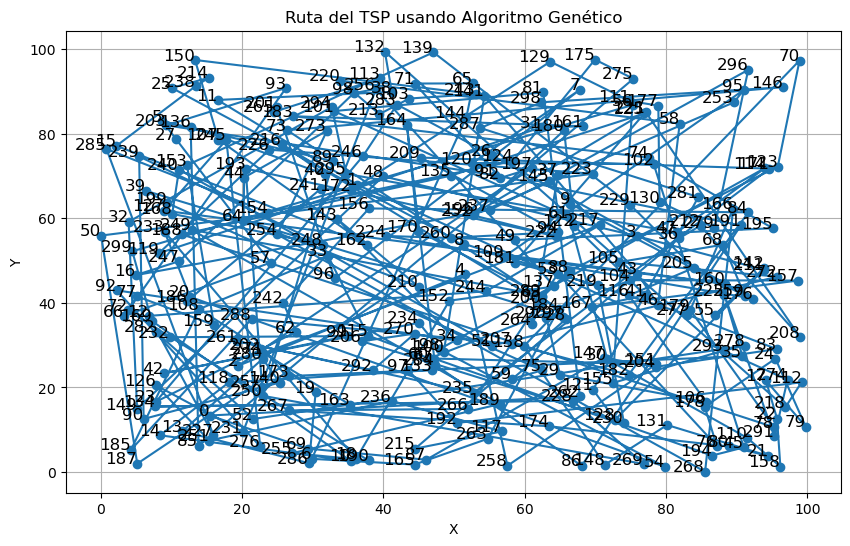

In [ ]:
#Graficares la ruta

mostrar_resultado(coordenadas, mejor_ruta_gen)

In [ ]:
poblacion = generar_poblacion_inicial(150, ciudades)
poblacion

[[111,
  143,
  100,
  287,
  6,
  210,
  117,
  18,
  83,
  61,
  291,
  139,
  211,
  186,
  106,
  24,
  120,
  16,
  289,
  105,
  219,
  299,
  34,
  278,
  152,
  163,
  134,
  45,
  55,
  17,
  294,
  230,
  187,
  81,
  235,
  5,
  180,
  221,
  108,
  201,
  35,
  110,
  70,
  98,
  132,
  273,
  222,
  76,
  233,
  77,
  58,
  125,
  181,
  135,
  223,
  203,
  155,
  23,
  127,
  207,
  89,
  12,
  198,
  87,
  145,
  29,
  99,
  193,
  267,
  0,
  179,
  137,
  68,
  86,
  57,
  277,
  256,
  252,
  64,
  28,
  92,
  298,
  95,
  174,
  25,
  245,
  185,
  75,
  266,
  264,
  262,
  9,
  194,
  154,
  205,
  257,
  67,
  13,
  93,
  46,
  168,
  153,
  8,
  146,
  49,
  204,
  225,
  195,
  130,
  178,
  173,
  42,
  73,
  212,
  94,
  261,
  159,
  236,
  37,
  116,
  280,
  250,
  170,
  218,
  119,
  171,
  63,
  53,
  282,
  102,
  156,
  269,
  240,
  11,
  74,
  285,
  59,
  109,
  200,
  288,
  182,
  296,
  196,
  48,
  101,
  150,
  36,
  290,
  175,
  160,
  206,


In [ ]:
def nearest_neighbor(graph, start_node):
    num_nodes = len(graph)
    visited = set()
    visited.add(start_node)
    route = [start_node]
    
    while len(visited) < num_nodes:
        current_node = route[-1]
        next_node = min((node for node in range(num_nodes) if node not in visited), 
                         key=lambda node: graph[current_node][node])
        visited.add(next_node)
        route.append(next_node)
    
    return route + [route[0]]  # Cerrar el circuito

def twogap(graph):
    num_nodes = len(graph)
    best_distance = float('inf')
    best_route = None
    
    for _ in range(100):  # Iteraciones de búsqueda local
        route = nearest_neighbor(graph, np.random.randint(num_nodes))
        distance = sum(graph[route[i]][route[i+1]] for i in range(len(route)-1))
        
        if distance < best_distance:
            best_distance = distance
            best_route = route
    
    return best_distance, best_route